# <center>Machine Learning Project Code - Group 12</center>


The members of the `team` 12 are:
- Ricardo Isidro - 20250374
- Rodrigo Santos - 20250387
- Rodrigo Teixeira - 20250393

Github link: https://github.com/rodbarretoteixeira/ProjetoML

# **Imports**

In [163]:

import os
import sqlite3
import warnings
import importlib
import random
from itertools import combinations
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import ipywidgets as widgets

from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE, SequentialFeatureSelector, SelectKBest, mutual_info_regression
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor, 
    ExtraTreesRegressor,
    BaggingRegressor, 
    VotingRegressor,
    StackingRegressor
)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from scipy.stats import randint, uniform

import functionsML as f
importlib.reload(f)

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_style("whitegrid") 

### **Import data sets**

In [8]:
train_db = pd.read_csv("./train.csv")
test_db = pd.read_csv("./test.csv")

# **Group Member Contribution**

Ricardo Isidro (37%) Responsible for the initial phase of the project. He conducted the Exploratory Data Analysis (EDA) to gain a deep understanding of the data and developed the core data cleaning functions. Within the scope of data engineering, he worked on Feature Engineering and Feature Selection to optimize model performance. Additionally, he authored the IV. Open-Ended Section, exploring extra approaches and in-depth analyses of model behavior.

Rodrigo Teixeira (33%) Actively collaborated in the preprocessing and data cleaning phase, ensuring dataset consistency. His primary focus was on the modeling architecture, where he implemented and tested various algorithms. He was responsible for the technical evaluation of error metrics, with a specific focus on MAE (Mean Absolute Error) and $R^2$, ensuring the models met the established performance requirements.


Rodrigo Santos (30%) Focused on refining variables through Feature Engineering, with particular attention to categorical data transformation and normalization techniques. He played a decisive role in the modeling phase, working on hyperparameter tuning (fine-tuning) and the comparative analysis between the tested models.

# **Abstract**

Cars 4 You is an online car resale platform that currently relies on a manual evaluation process conducted by a chain of mechanics. Due to business growth, increasing waiting lists for these inspections have led to customer dissatisfaction and potential loss of business to competitors.

The primary goal of this project is to develop a predictive machine learning model capable of accurately estimating car prices based on user-provided details, avoiding the wait time created by the car's inspection. And we will be embedding said model in an interface where the users will be able to run their predictions.

Utilizing a dataset of car sales from 2020, we performed rigorous data exploration and preprocessing to address significant data quality issues, including typos in categorical (like Model Brand Tansmission and FuelType) features and irrational or negative numerical values (where should only be natural ones). We ran various machine learning models and selected the best one for our case. We also adopted a specialized modeling strategy by splitting the data into "Luxury" (like Mercedes Audi BMW) and "non-luxury" (all the remaining brands) segments to account for different pricing behaviors.

Main Results & Conclusions: We will be using the ensemble split, since it was our best predictor that also didn't apear to have overfitting issues

# **I. Identifying Business Needs**

The core business need for Cars 4 You is a model capable of predicting a car's price given its information provided by the user. This is due to the manual bottleneck of physical inspections hindering scalability and growth. The project focuses on three primary objectives:

    -Cleaning and treating the data: Our client has given us their database from 2020, but many inputs have missing/wrong values that we need to treat. We will also be optimizing our features so they can serve our models better.

    -Model Assessment Strategy: Implementing a rigorous framework to compare different algorithms to find the most robust solution.

    -Deployment: Implementing our best model in an interface.

The overall process follows a standard ML pipeline with Data Cleaning, Feature Engineering, Feature Selection, Model Training and Validation.

To ensure the model generalizes well to new, unseen customer data, we adopted a Holdout Strategy.
The initial dataset was split into a training set (70%) and a validation set (30%) using a fixed random state to ensure reproducibility. 
This approach was chosen to prevent data leakage during the cleaning and encoding phases. This separation allows for an unbiased assessment of the model's performance.

We ended up selecting our model acording to the MAE metric, because MAE maintains the same unit as our target variable: **Euros**. This allows us to communicate results clearly to stakeholders. The MAE tells us exactly how many Euros, on average, our price predictions deviate from the actual market value. In the vehicle valuation business, this clarity is vital for making informed decisions regarding profit margins and competitive pricing.

# **II. Data Exploration and Preprocessing**

The first thing we do is split the data, so we can prevent any sort of leakage from happening

In [9]:
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=2, shuffle=True)

Our goal here is to understand the data, and the possible issues that come with it

In [10]:
train_set.head(15)

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
11446,35675,Mercedes,NaN,2016.0,37385,Automatic,21169.0,Diesel,305.0,37.2,3.0,42.0,3.0,0.0
42107,72523,VW,Passat,2016.0,8000,Manual,101370.0,Diesel,20.0,70.6,1.6,81.0,3.0,0.0
42568,26747,Ford,Fiesta,2015.0,6700,Manual,41406.0,Petrol,125.0,54.3,1.2,85.0,4.0,0.0
56466,44023,NaN,GLE Class,2019.0,47390,Semi-Auto,9500.0,Diesel,145.0,36.7,2.0,35.0,0.0,0.0
41646,73041,VW,Golf,2016.0,20990,Semi-Auto,28406.0,Petrol,205.0,39.8,2.0,84.0,1.0,0.0
37445,3113,Audi,A1,2019.0,21445,Semi-Auto,5844.0,Petrol,150.0,40.4,2.0,73.0,4.0,0.0
71382,46250,Mercede,C Class,2014.0,16964,Automatic,20281.0,Diesel,NaN,NaN,2.1,94.0,3.0,0.0
75713,54045,Toyota,Aygo,2017.0,6995,Manual,8932.0,NaN,145.0,69.0,1.0,76.0,0.0,0.0
66927,55032,Toyota,Auris,2017.0,10698,Manual,NaN,diesel,150.0,67.3,1.6,71.0,1.0,0.0
60696,64930,Opel,Astra,2017.0,10530,Manual,21845.0,Diesel,0.0,83.1,1.6,51.0,1.0,0.0


- Typos in transmission and fuel

- EngineSize with NaN

- Mileage, mpg and previousOwners with irrational values

- PreviousOwners with negative values

- hasDamage seems to always be 0

In [11]:
train_set.describe(include='object')

,Brand,model,transmission,fuelType
count,52096,52125,52133,52109
unique,69,682,39,34
top,Ford,Focus,Manual,Petrol
freq,10375,4469,26733,26642


- The categorical variables have a lot of unique values

In [12]:
train_set.describe()

,carID,year,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,53181.000000,52150.000000,53181.000000,52136.000000,47626.000000,47602.000000,52123.000000,52136.000000,52088.000000,52101.0
mean,38022.666009,2017.102655,16867.168820,23010.701255,120.376201,55.111169,1.658290,64.520649,1.989224,0.0
std,21915.140171,2.213196,9756.826483,22158.932549,65.410970,16.246049,0.572962,21.005830,1.471792,0.0
min,0.000000,1970.000000,450.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,19051.000000,2016.000000,10199.000000,7416.500000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,38031.000000,2017.000000,14690.000000,17270.500000,145.000000,54.300000,1.600000,64.000000,2.000000,0.0
75%,56979.000000,2019.000000,20900.000000,32428.000000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,75972.000000,2024.121759,159999.000000,323000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


- Missing values in year mileage tax mpg engineSize paintQuality% previousOwners and hasDamage

- Alarming min values in mileage tax mpg engineSize paintQuality% previousOwners

- Alarming max values in year mpg paintQuality% previousOwners

- HasDamage is always 0

In [13]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53181 entries, 11446 to 72173
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           53181 non-null  int64  
 1   Brand           52096 non-null  object 
 2   model           52125 non-null  object 
 3   year            52150 non-null  float64
 4   price           53181 non-null  int64  
 5   transmission    52133 non-null  object 
 6   mileage         52136 non-null  float64
 7   fuelType        52109 non-null  object 
 8   tax             47626 non-null  float64
 9   mpg             47602 non-null  float64
 10  engineSize      52123 non-null  float64
 11  paintQuality%   52136 non-null  float64
 12  previousOwners  52088 non-null  float64
 13  hasDamage       52101 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 6.1+ MB


- Year is float64, should be int64

- PreviousOwners is float, should be int64

In [14]:
f.missing_values_table(train_set)

Total columns: 14
Columns with missing values: 12



,Missing Values,Percent Missing (%)
mpg,5579,10.49
tax,5555,10.45
previousOwners,1093,2.06
Brand,1085,2.04
hasDamage,1080,2.03
fuelType,1072,2.02
model,1056,1.99
engineSize,1058,1.99
transmission,1048,1.97
mileage,1045,1.96


In [15]:
f.negative_values_table(train_set)
# In this context negative numbers don't make sense

Total numeric columns: 10
Columns with negative values: 5



,Negative Values,Percent Negative (%)
tax,274,0.52
previousOwners,262,0.49
mileage,247,0.46
engineSize,60,0.11
mpg,29,0.05


In [16]:
f.irrational_values_table(train_set)
# Realistically none of the numerical variables should have entries with more than 1-2 decimals

Total numeric columns: 10
Columns with irrational values: 7
Rows with at least one irrational value: 3564



,Irrational Count,Percent Irrational (%)
engineSize,552,1.04
tax,535,1.01
mpg,525,0.99
year,522,0.98
mileage,511,0.96
previousOwners,510,0.96
paintQuality%,495,0.93
Total (rows with any irrational value),3564,6.70


## **Unique Values**

We wanted to take a better look at what kind of values each variable had, and we ended up finding:

- Typos in every categorical variable

- Different letter casing in every categorical variable

- Unrealistic negative values and irrational values in every numerical category

In [17]:
# Loop through each column in the DataFrame
for column in train_set.columns:

    # Print unique values and count for columns with fewer than 20 unique values
    print(f"Unique values in '{column}': {train_set[column].unique()}")
    print(f"Number of unique values: {train_set[column].nunique()}\n")


Unique values in 'carID': [35675 72523 26747 ...  2624 65485 75219]
Number of unique values: 53181

Unique values in 'Brand': ['Mercedes' 'VW' 'Ford' nan 'Audi' 'Mercede' 'Toyota' 'Opel' 'Skoda'
 'Hyundai' 'BMW' 'For' 'audi' 'ord' 'mercedes' 'V' 'MW' 'W' 'SKODA' 'ford'
 'HYUNDAI' 'ercedes' 'AUDI' 'FORD' 'OPEL' 'pel' 'Hyunda' 'opel' 'vw' 'mw'
 'udi' 'MERCEDES' 'Aud' 'ORD' 'Ope' 'TOYOTA' 'skoda' 'bmw' 'oyota' 'BM'
 'yundai' 'koda' 'hyundai' 'for' 'pe' 'Toyot' 'Skod' 'toyota' 'v' 'HYUNDA'
 'w' 'ope' 'ercede' 'ERCEDES' 'OPE' 'yunda' 'aud' 'or' 'ud' 'kod'
 'MERCEDE' 'OYOTA' 'AUD' 'FOR' 'PEL' 'hyunda' 'mercede' 'toyot' 'UDI'
 'skod']
Number of unique values: 69

Unique values in 'model': [nan ' Passat' ' Fiesta' ' GLE Class' ' Golf' ' A1' ' C Class' ' Aygo'
 ' Auris' ' Astra' ' Focus' ' Polo' ' Citigo' ' I10' ' EcoSport'
 ' 3 Series' ' CROSSLAND X' ' focus' ' A3' ' Q3' ' Scirocco' ' Galaxy'
 ' Kuga' ' Q5' ' X2' ' KA' ' 4 Series' ' Fabia' ' Up' ' Ka+' ' Arteon'
 ' Insignia' ' YARIS' ' Viva' '

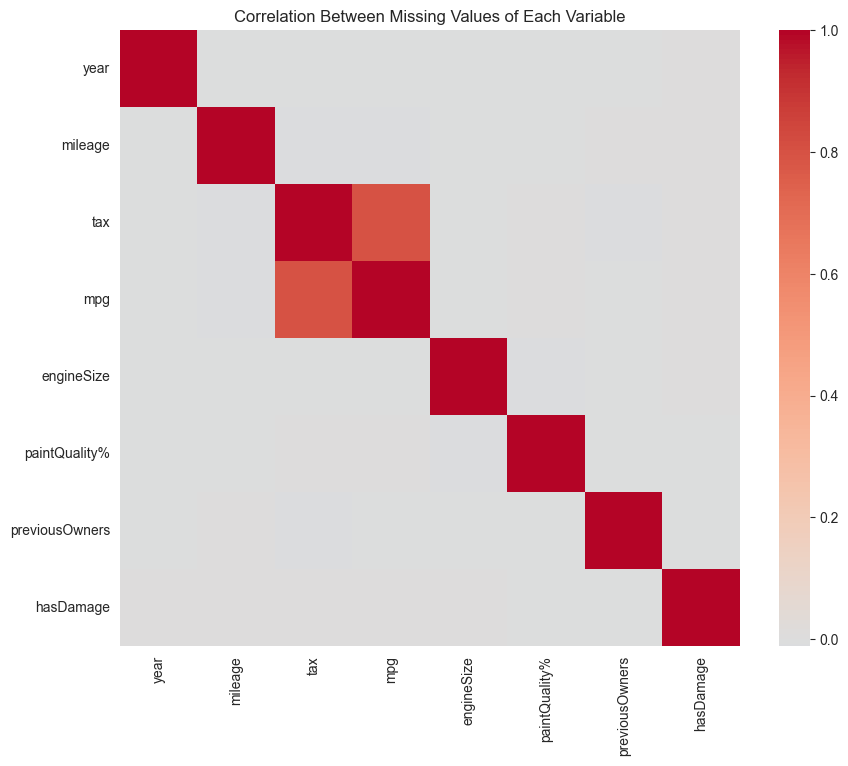

In [18]:

missing_mask = train_set.drop(columns=["carID", "price"], errors="ignore").select_dtypes(include=["number"]).isna()

missing_corr = missing_mask.corr(method="spearman")

# Plot the correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(missing_corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Between Missing Values of Each Variable")
plt.show()

- There is a strong correlation between mpg's and tax's missing values so we will create a new feature that flags every entry that had both missing before filling 

In [19]:
train_set['tax_and_mpg_missing'] = (train_set['tax'].isna() & train_set['mpg'].isna()).astype(int)
val_set['tax_and_mpg_missing'] = (val_set['tax'].isna() & val_set['mpg'].isna()).astype(int)

## **Distributions & Value Counts**

In [20]:
train_set["Brand"].value_counts()

Brand
Ford        10375
Mercedes     7545
VW           6842
Opel         6039
BMW          4838
            ...  
mercede         2
PEL             1
AUD             1
toyot           1
skod            1
Name: count, Length: 69, dtype: int64

In [21]:
train_set["model"].value_counts()

model
 Focus             4469
 C Class           3407
 Fiesta            2890
 Golf              2147
 Corsa             1518
                   ... 
GTC                   1
 tourneo custom       1
Scala                 1
Toura                 1
yaris                 1
Name: count, Length: 682, dtype: int64

- Some entries also have space characters

In [22]:
train_set["transmission"].value_counts()

transmission
Manual       26733
Semi-Auto    10890
Automatic     9753
anual          571
MANUAL         560
manual         534
Manua          525
unknown        489
 Manual        248
semi-auto      232
utomatic       224
Semi-Aut       220
emi-Auto       211
AUTOMATIC      206
SEMI-AUTO      204
Automati       202
automatic      196
unknow          15
UNKNOWN         10
anua            10
ANUAL           10
Manual           9
SEMI-AUT         9
MANUA            9
EMI-AUTO         7
emi-auto         7
utomati          6
 manual          5
AUTOMATI         5
 Manual          5
 MANUAL          5
nknown           5
semi-aut         4
automati         4
Other            3
emi-Aut          3
manua            2
manual           1
UTOMATIC         1
Name: count, dtype: int64

In [23]:
train_set["fuelType"].value_counts()

fuelType
Petrol      26642
Diesel      19918
Hybrid       1420
etrol         553
Petro         547
PETROL        532
petrol        504
iesel         427
diesel        418
Diese         418
DIESEL        405
Other         103
HYBRID         39
hybrid         36
Hybri          26
ybrid          24
etro           13
PETRO          12
petro          10
IESEL          10
ETROL          10
iese            8
DIESE           7
ther            5
diese           5
Othe            3
Electric        3
HYBRI           2
YBRID           2
other           2
OTHER           2
ETRO            1
IESE            1
ybri            1
Name: count, dtype: int64

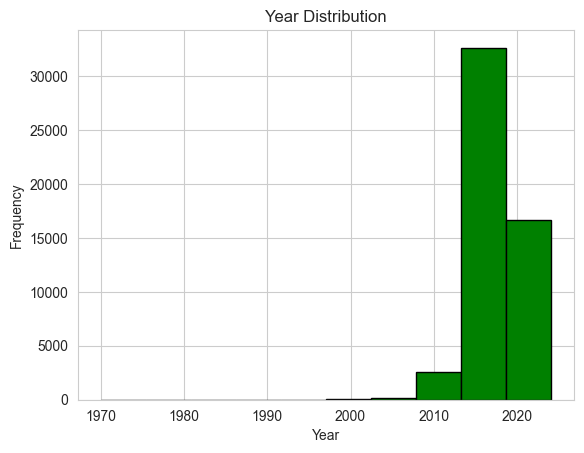

In [24]:
# Plot histogram for the "year" column
f.plot_histogram(train_set["year"], 
                 "Year",         # x-axis label
                 "Frequency",   # y-axis label
                 "Year Distribution")  # title of the plot

- The distribuition is very right side heavy, with only a few entries before the year 2000

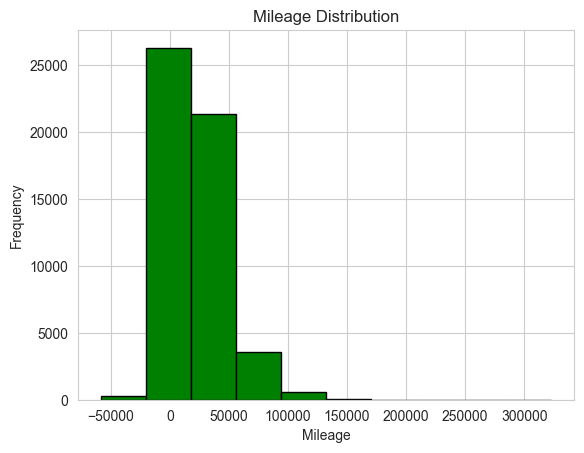

In [25]:
# Plot histogram for the "mileage" column
f.plot_histogram(train_set["mileage"], 
                 "Mileage",         # x-axis label
                 "Frequency",   # y-axis label
                 "Mileage Distribution")  # title of the plot

- There are some entries with negative mileage

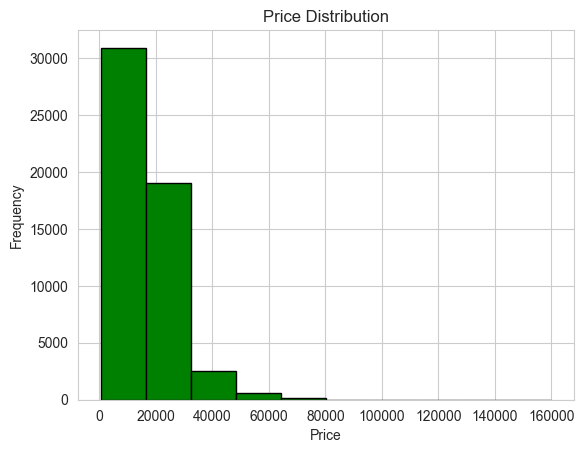

In [26]:
# Plot histogram for the "price" column
f.plot_histogram(train_set["price"], 
                 "Price",         # x-axis label
                 "Frequency",   # y-axis label
                 "Price Distribution")  # title of the plot

- The distribuition is very heavy on the lower end of prices

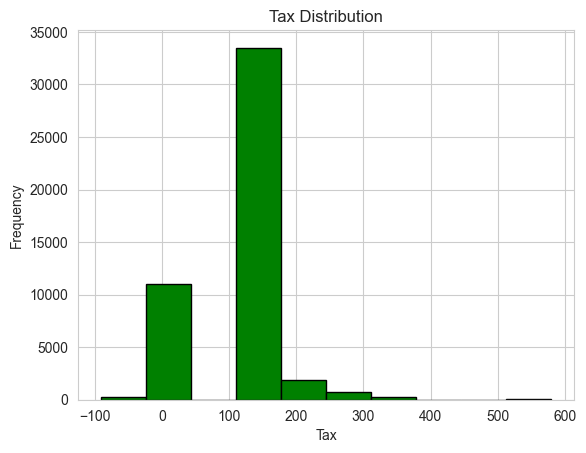

In [27]:
# Plot histogram for the "tax" column
f.plot_histogram(train_set["tax"], 
                 "Tax",         # x-axis label
                 "Frequency",   # y-axis label
                 "Tax Distribution")  # title of the ploty

- There are negative tax values and there is a gap between entries with 0 tax and 100

- The majirity of the entries are between 100 and 200 dollars

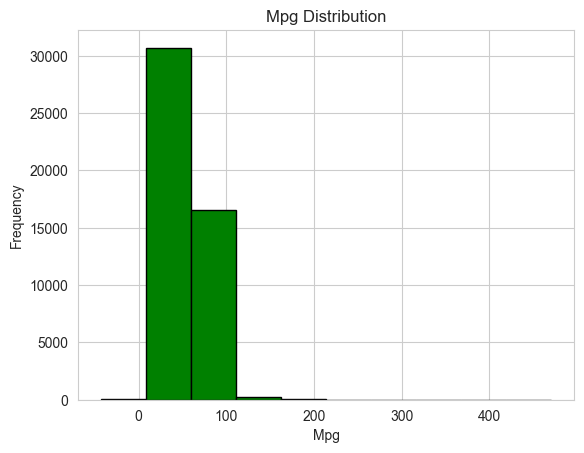

In [28]:
# Plot histogram for the "mpg" column
f.plot_histogram(train_set["mpg"], 
                 "Mpg",         # x-axis label
                 "Frequency",   # y-axis label
                 "Mpg Distribution")  # title of the ploty

- There are a few negative values and values over 100

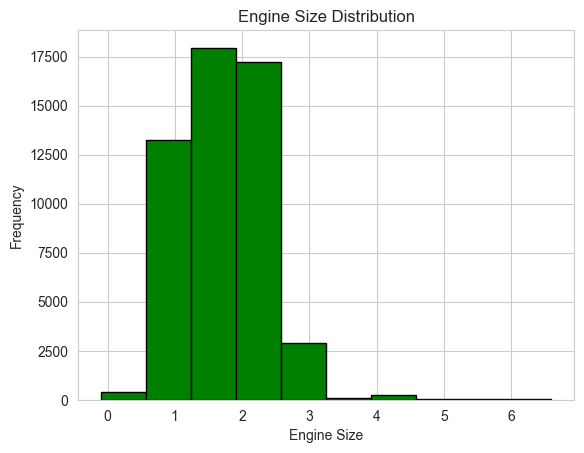

In [29]:
# Plot histogram for the "engineSize" column
f.plot_histogram(train_set["engineSize"], 
                 "Engine Size",         # x-axis label
                 "Frequency",   # y-axis label
                 "Engine Size Distribution")  # title of the ploty

- Engine sizes at 0, and a few above 3

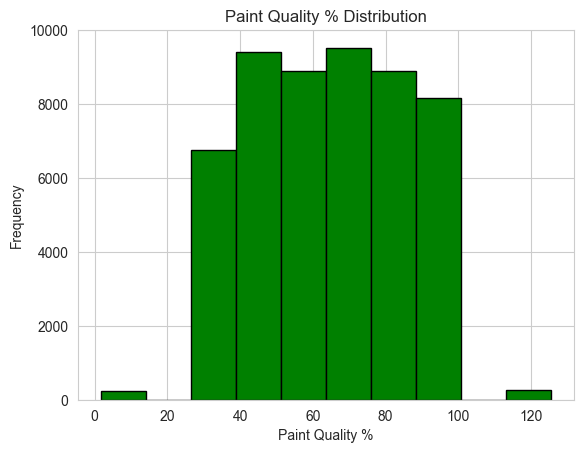

In [30]:
# Plot histogram for the "paintQuality%" column
f.plot_histogram(train_set["paintQuality%"], 
                 "Paint Quality %",         # x-axis label
                 "Frequency",   # y-axis label
                 "Paint Quality % Distribution")  # title of the ploty

- Paint quality entries above 100 dont make sense, since the variable is a percentage

- There is also a small chuck of entries close to 0

## **Fixing issues**

#### Here we aim to treat the spotted issues, outliers and NaN values

In [31]:
# - Drop irrelevant column -
# they can only be obtained by the mechanic, so they don't hold any relevancy to us
train_set = train_set.drop(columns=["hasDamage","paintQuality%"])

train_set_numerical = train_set.select_dtypes(exclude=["object"]).columns

# - Fixing text columns -
# there are a lot of typos and different casings in all of the text columns
text_cols = train_set.select_dtypes(include=["object"]).columns
train_set[text_cols] = train_set[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
for col in text_cols:
    train_set = f.fix_typos(col, train_set)




In [32]:
model_counts = train_set['model'].value_counts()

# 3. Filter for models that appear between 1 and 3 times
rare_models = model_counts[(model_counts >= 1) & (model_counts <= 5)]

rare_models

model
eos              5
z3               5
supra            5
caddy life       4
getz             4
clk              4
grandland        3
caddy            3
iq               3
kadjar           3
vectra           2
cascada          2
urban cruiser    2
m6               2
ampera           2
verso-s          2
s8               2
caddy maxi       2
veloste          1
200              1
i1               1
230              1
escort           1
ranger           1
streetka         1
accent           1
220              1
clc class        1
Name: count, dtype: int64

In [33]:
# We do the same thing for val_set

# - Drop irrelevant column -
val_set = val_set.drop(columns=["hasDamage", "paintQuality%"])

val_set_numerical = val_set.select_dtypes(exclude=["object"]).columns


# - Fixing text columns -
text_cols = val_set.select_dtypes(include=["object"]).columns
val_set[text_cols] = val_set[text_cols].apply(lambda x: x.str.lower() if x.dtype == "object" else x)
for col in text_cols:
    val_set = f.fix_typos(col, val_set)

### **Outlier treatment**

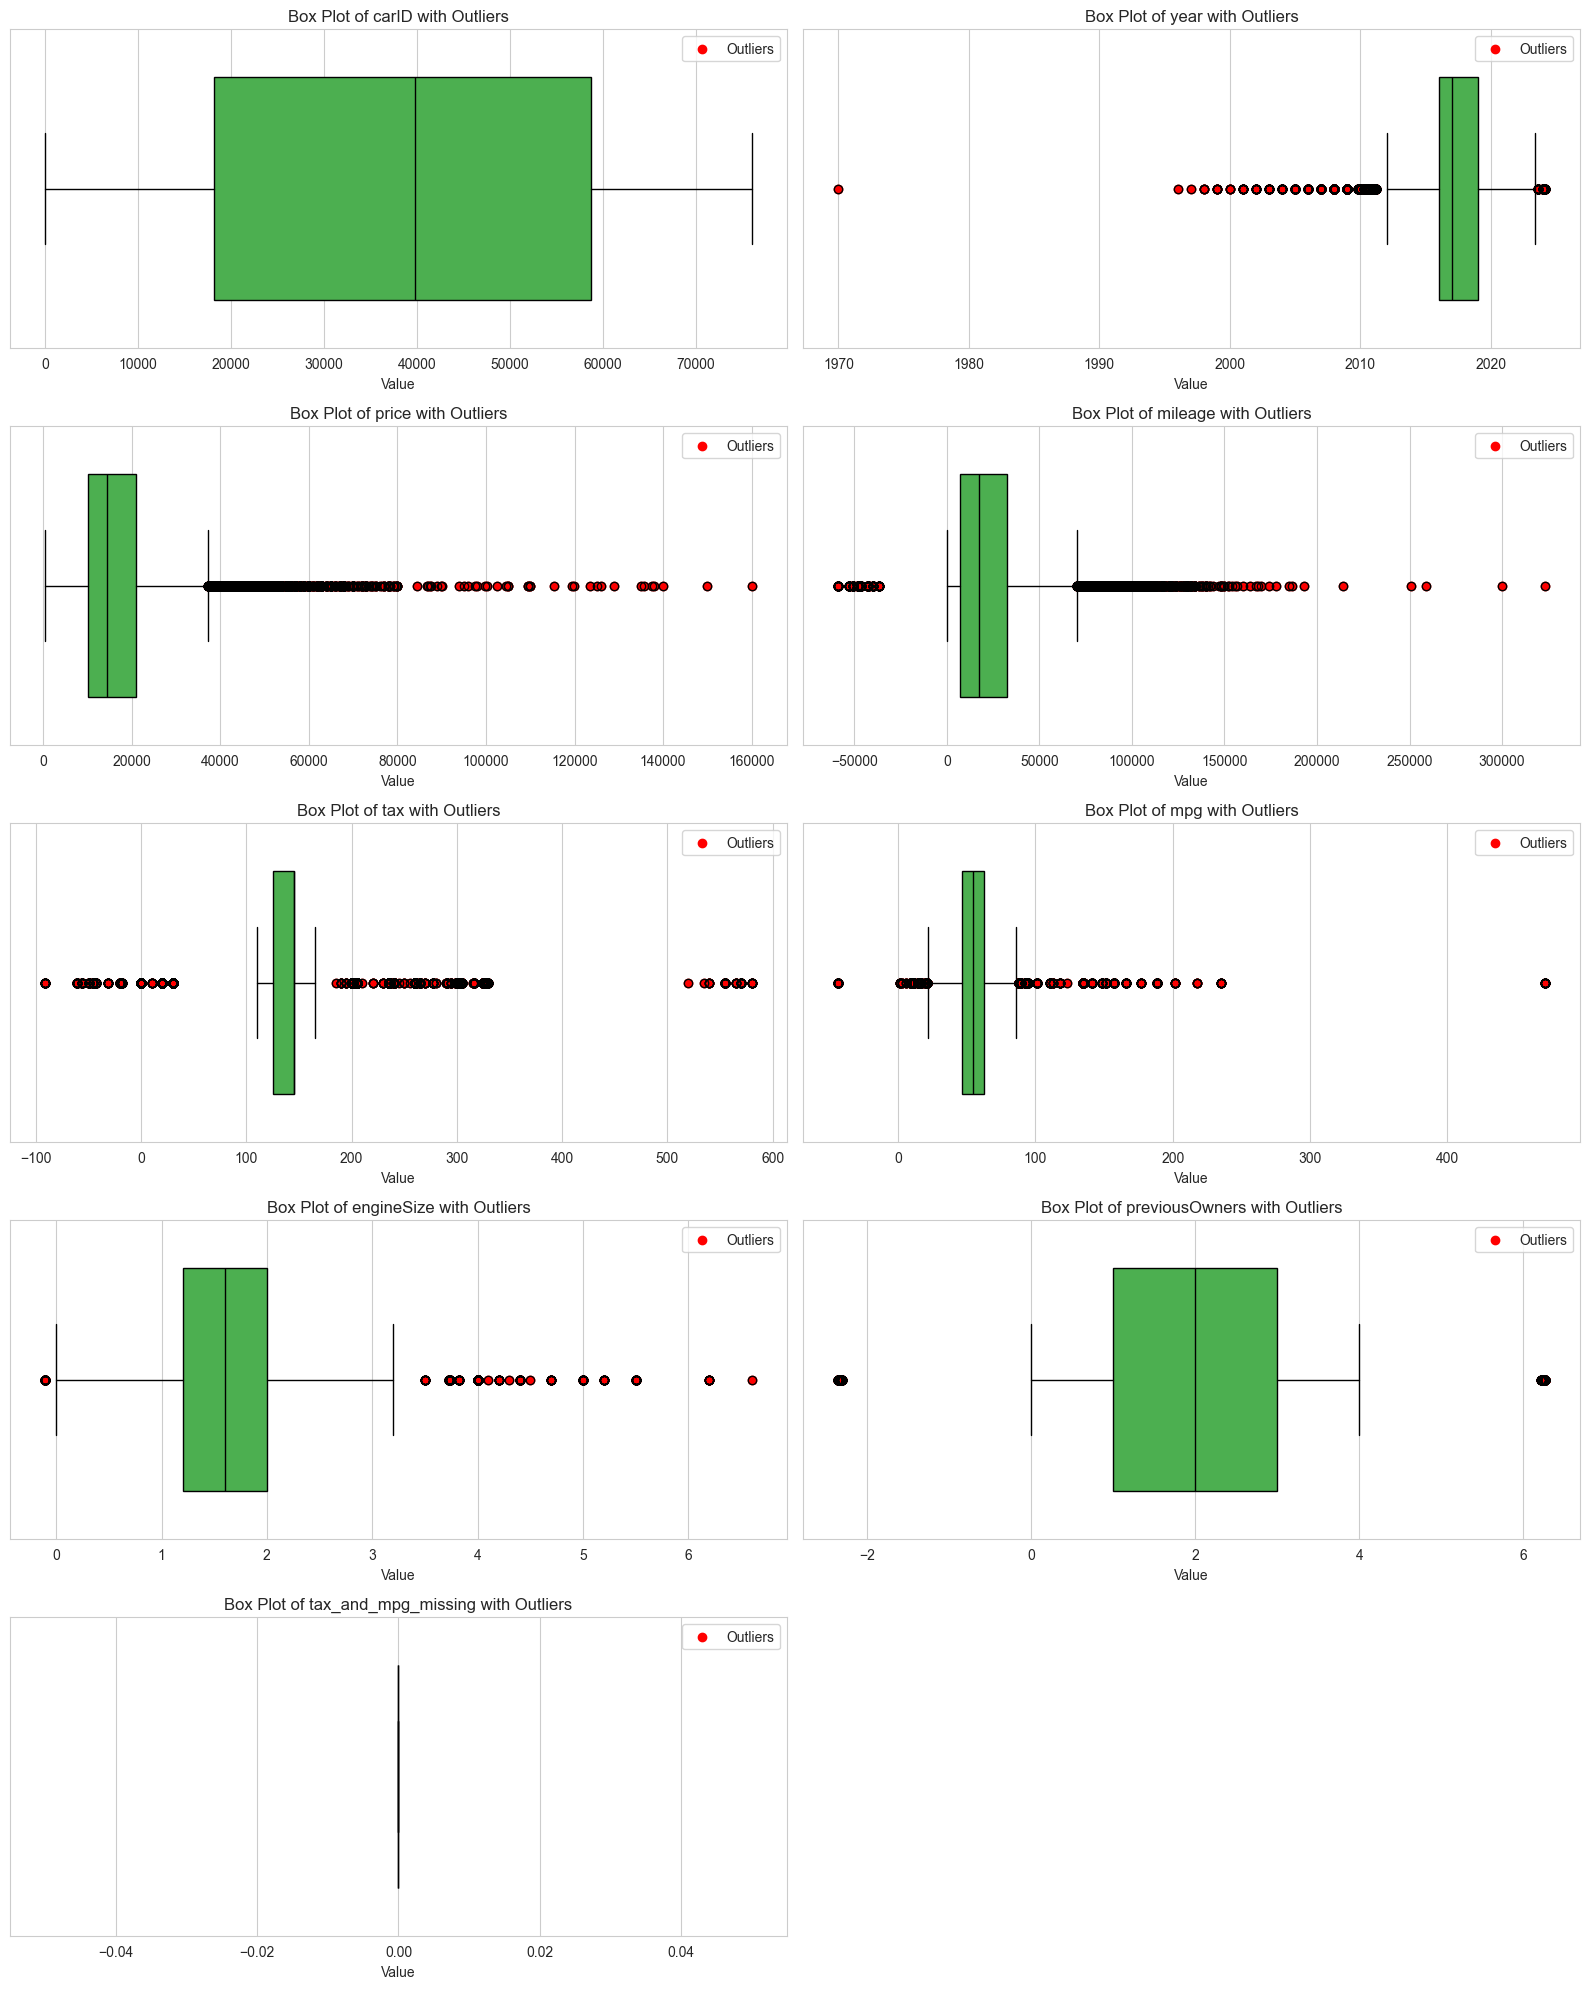

In [34]:
f.plot_multiple_boxes_with_outliers(train_set.dropna(), train_set_numerical)

- We can imideatly spot some issues on the graphs, including absurd values and values that don't make sense

##### We analyzed some variables using .value_counts() so we could better assess whether they contained significant entries or absurd/outlier values

In [35]:
year_below_1999 = train_set[train_set["year"] <= 1999]

# Display the filtered entries
year_below_1999["year"].value_counts()


year
1998.0    5
1999.0    5
1970.0    2
1997.0    1
1996.0    1
Name: count, dtype: int64

In [36]:
preivousOwners_above_4 = train_set[train_set["previousOwners"] > 4]

# Display the filtered entries
preivousOwners_above_4["previousOwners"].value_counts()

previousOwners
6.258231    56
6.245835    44
6.233082    34
6.258371    33
6.248251    23
6.230180    19
6.241779    14
6.217724    13
6.227898    12
Name: count, dtype: int64

In [37]:
# Removed replace absurd/incorrect values with NaN for them later to be filled

# Negative mileage values indicate data entry errors or corrupted records. 
# These values do not represent real-world mileage and would distort model training.
train_set.loc[train_set["mileage"] < 0, "mileage"] = np.nan 

# Car road tax cannot be negative
train_set.loc[train_set["tax"] < 0, "tax"] = np.nan 

# Mpg cannot be negative.
# Values above 150 mpg are unrealistic for traditional cars
train_set.loc[~train_set["mpg"].between(0, 150), "mpg"] = np.nan

# No engineSize value below 1 seems to be realistic and hold any significance
# Above 6.3 there is a single entry that seems to be a mistake, given that we have a substantial amount of entries with the same Brand and model and they never surpass 4.4
train_set.loc[~train_set["engineSize"].between(1, 6.3), "engineSize"] = np.nan

# There are only 2 entries before 1990 and they have a huge age gap between the oldest car after 1990 (26 years), so we treat every entry with year below 1990 as an absurd value
# The data set only includes data from up to 2020
train_set.loc[~train_set["year"].between(1990, 2020), "year"] = np.nan

# Previous owners below 0 makes no sense
# All of the entries above 4 seem to make no sense as they are all float values for a column that realistically should only have natural numbers
train_set.loc[~train_set["previousOwners"].between(0, 6), "previousOwners"] = np.nan


# We also need to exclude some abnormal values where there should only be natural numbers or doubles
mask = (train_set['year'] % 1 != 0)
train_set.loc[mask, 'year'] = np.nan
mask = (train_set['mileage'] % 1 != 0)
train_set.loc[mask, 'mileage'] = np.nan
mask = (train_set['tax'] % 1 != 0)
train_set.loc[mask, 'tax'] = np.nan
mask = train_set['mpg'] != train_set['mpg'].round(1)
train_set.loc[mask, 'mpg'] = np.nan
mask = train_set['engineSize'] != train_set['engineSize'].round(1)
train_set.loc[mask, 'engineSize'] = np.nan


In [38]:
# We do the exact same for the validation set
val_set.loc[val_set["mileage"] < 0, "mileage"] = np.nan 
val_set.loc[val_set["tax"] < 0, "tax"] = np.nan 
val_set.loc[~val_set["mpg"].between(0, 150), "mpg"] = np.nan
val_set.loc[~val_set["engineSize"].between(1, 6.3), "engineSize"] = np.nan
val_set.loc[~val_set["year"].between(1990, 2020), "year"] = np.nan
val_set.loc[~val_set["previousOwners"].between(0, 4), "previousOwners"] = np.nan

mask = (val_set['year'] % 1 != 0)
val_set.loc[mask, 'year'] = np.nan
mask = (val_set['mileage'] % 1 != 0)
val_set.loc[mask, 'mileage'] = np.nan
mask = (val_set['tax'] % 1 != 0)
val_set.loc[mask, 'tax'] = np.nan
mask = val_set['mpg'] != val_set['mpg'].round(1)
val_set.loc[mask, 'mpg'] = np.nan
mask = val_set['engineSize'] != val_set['engineSize'].round(1)
val_set.loc[mask, 'engineSize'] = np.nan


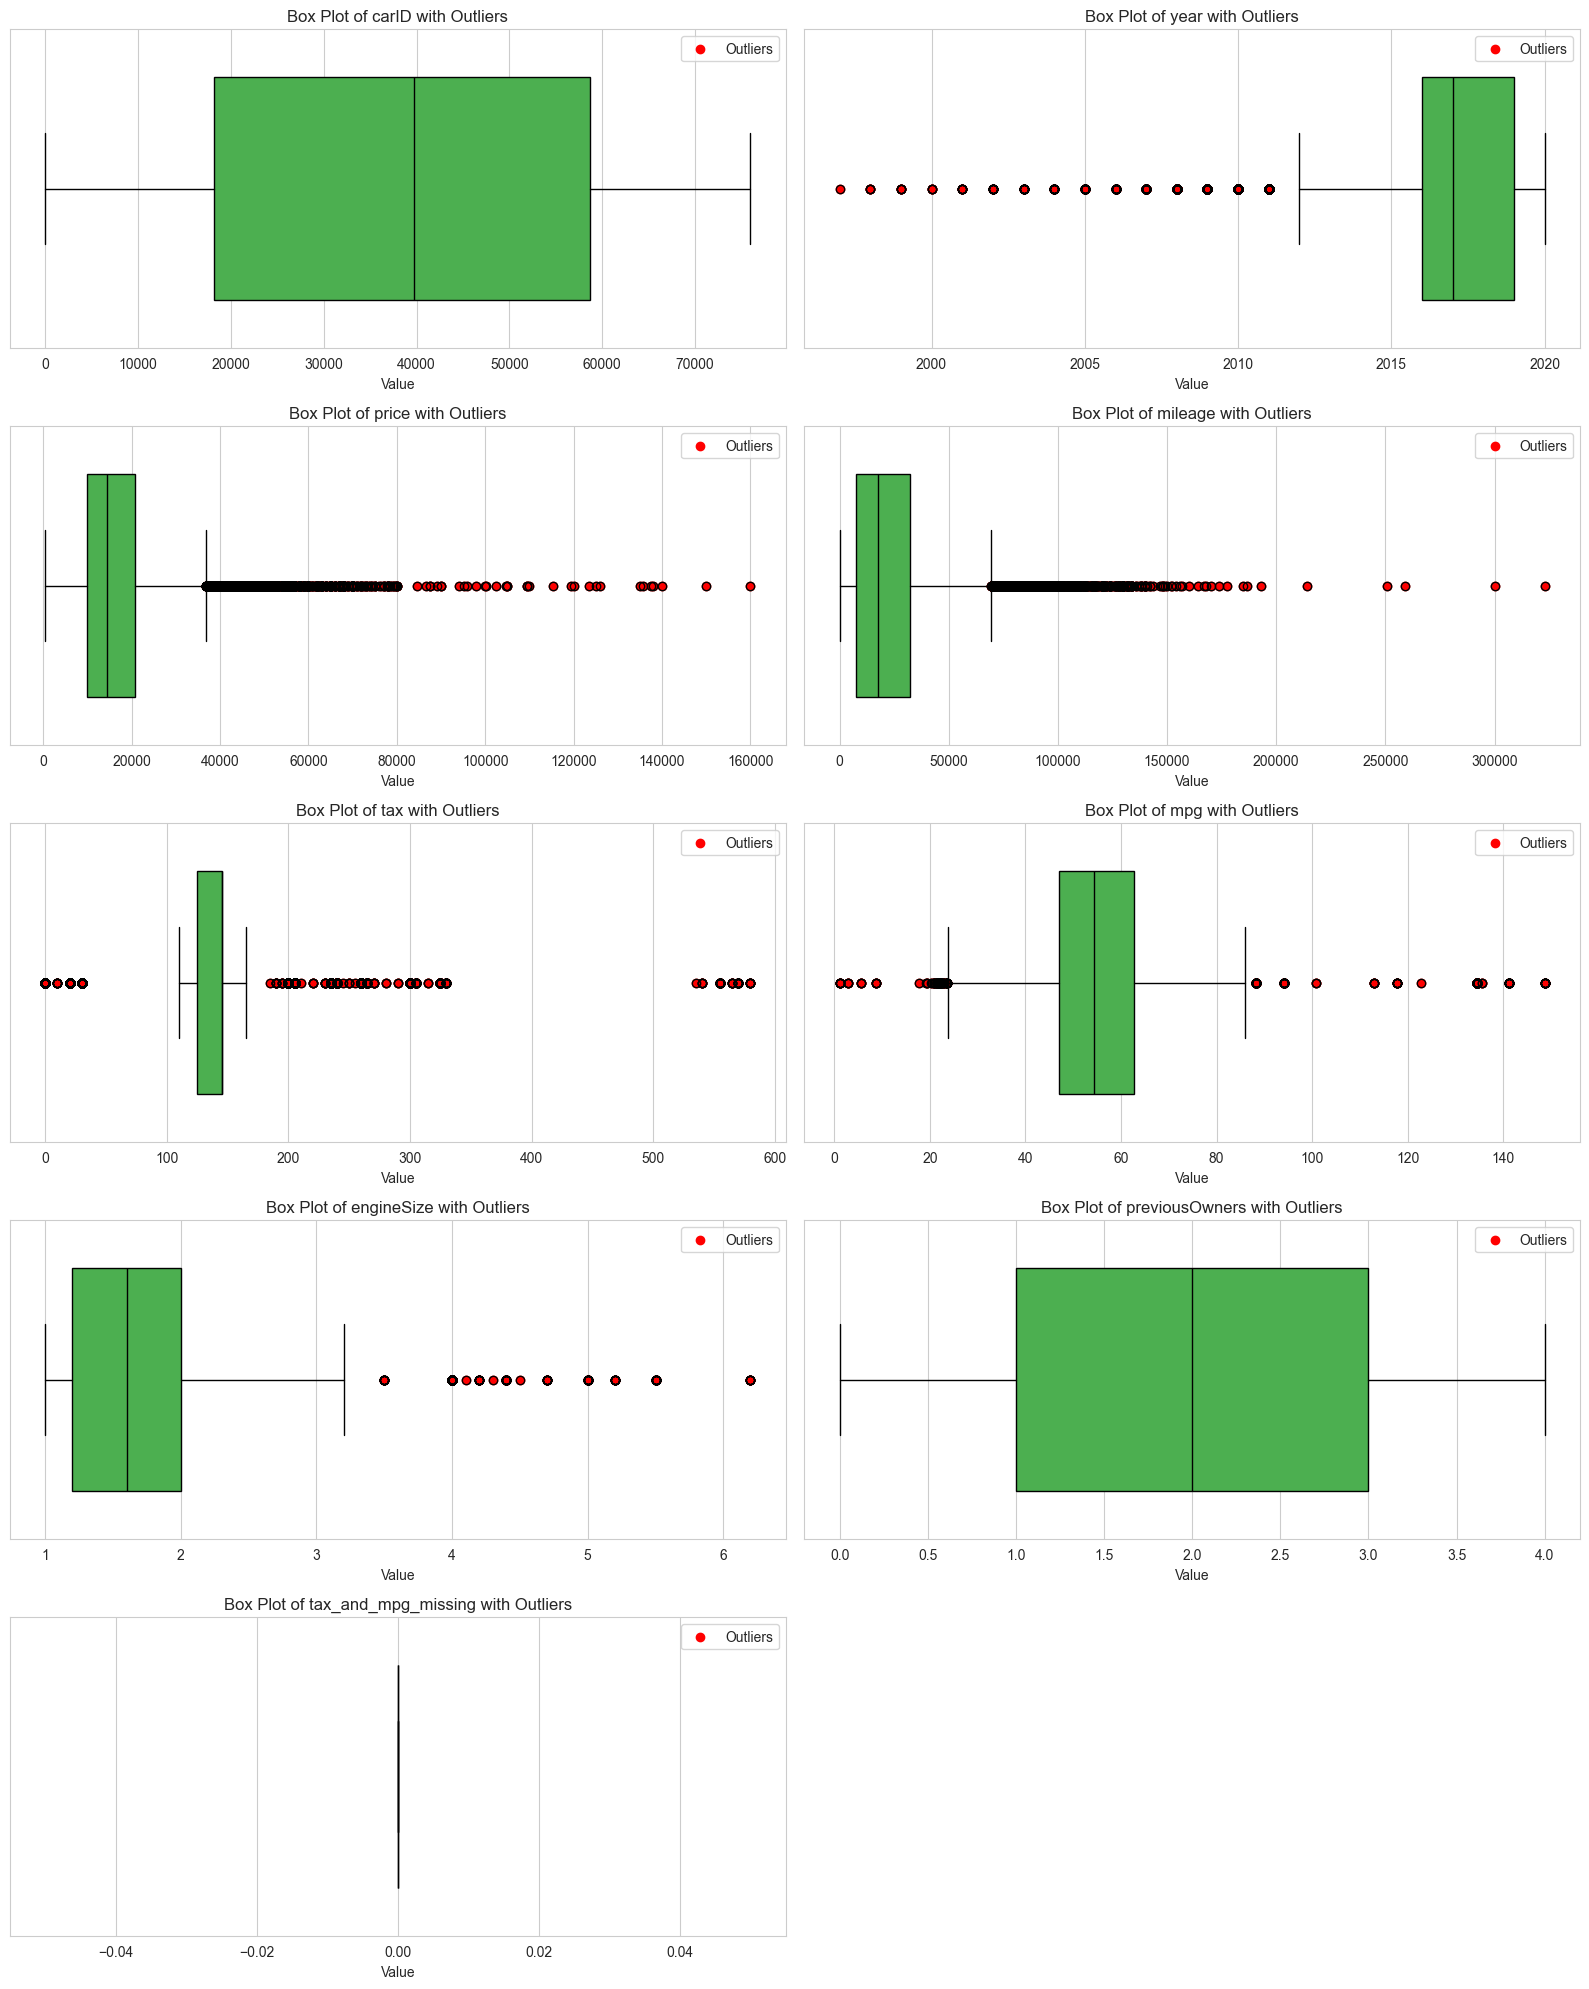

In [39]:
f.plot_multiple_boxes_with_outliers(train_set.dropna(), train_set_numerical)

#### Next we apply log(1 + x) transformation to reduce skewness and normalize distribution
##### This will help our model handle certain right-skewed variables better

In [40]:
train_set['price'] = np.log1p(train_set['price'])
train_set['tax'] = np.log1p(train_set['tax'])
train_set['mileage'] = np.log1p(train_set['mileage'])
train_set['mpg'] = np.log1p(train_set['mpg'])

In [41]:
# We do the exact same for the validation set
val_set['price'] = np.log1p(val_set['price'])
val_set['tax'] = np.log1p(val_set['tax'])
val_set['mileage'] = np.log1p(val_set['mileage'])
val_set['mpg'] = np.log1p(val_set['mpg'])


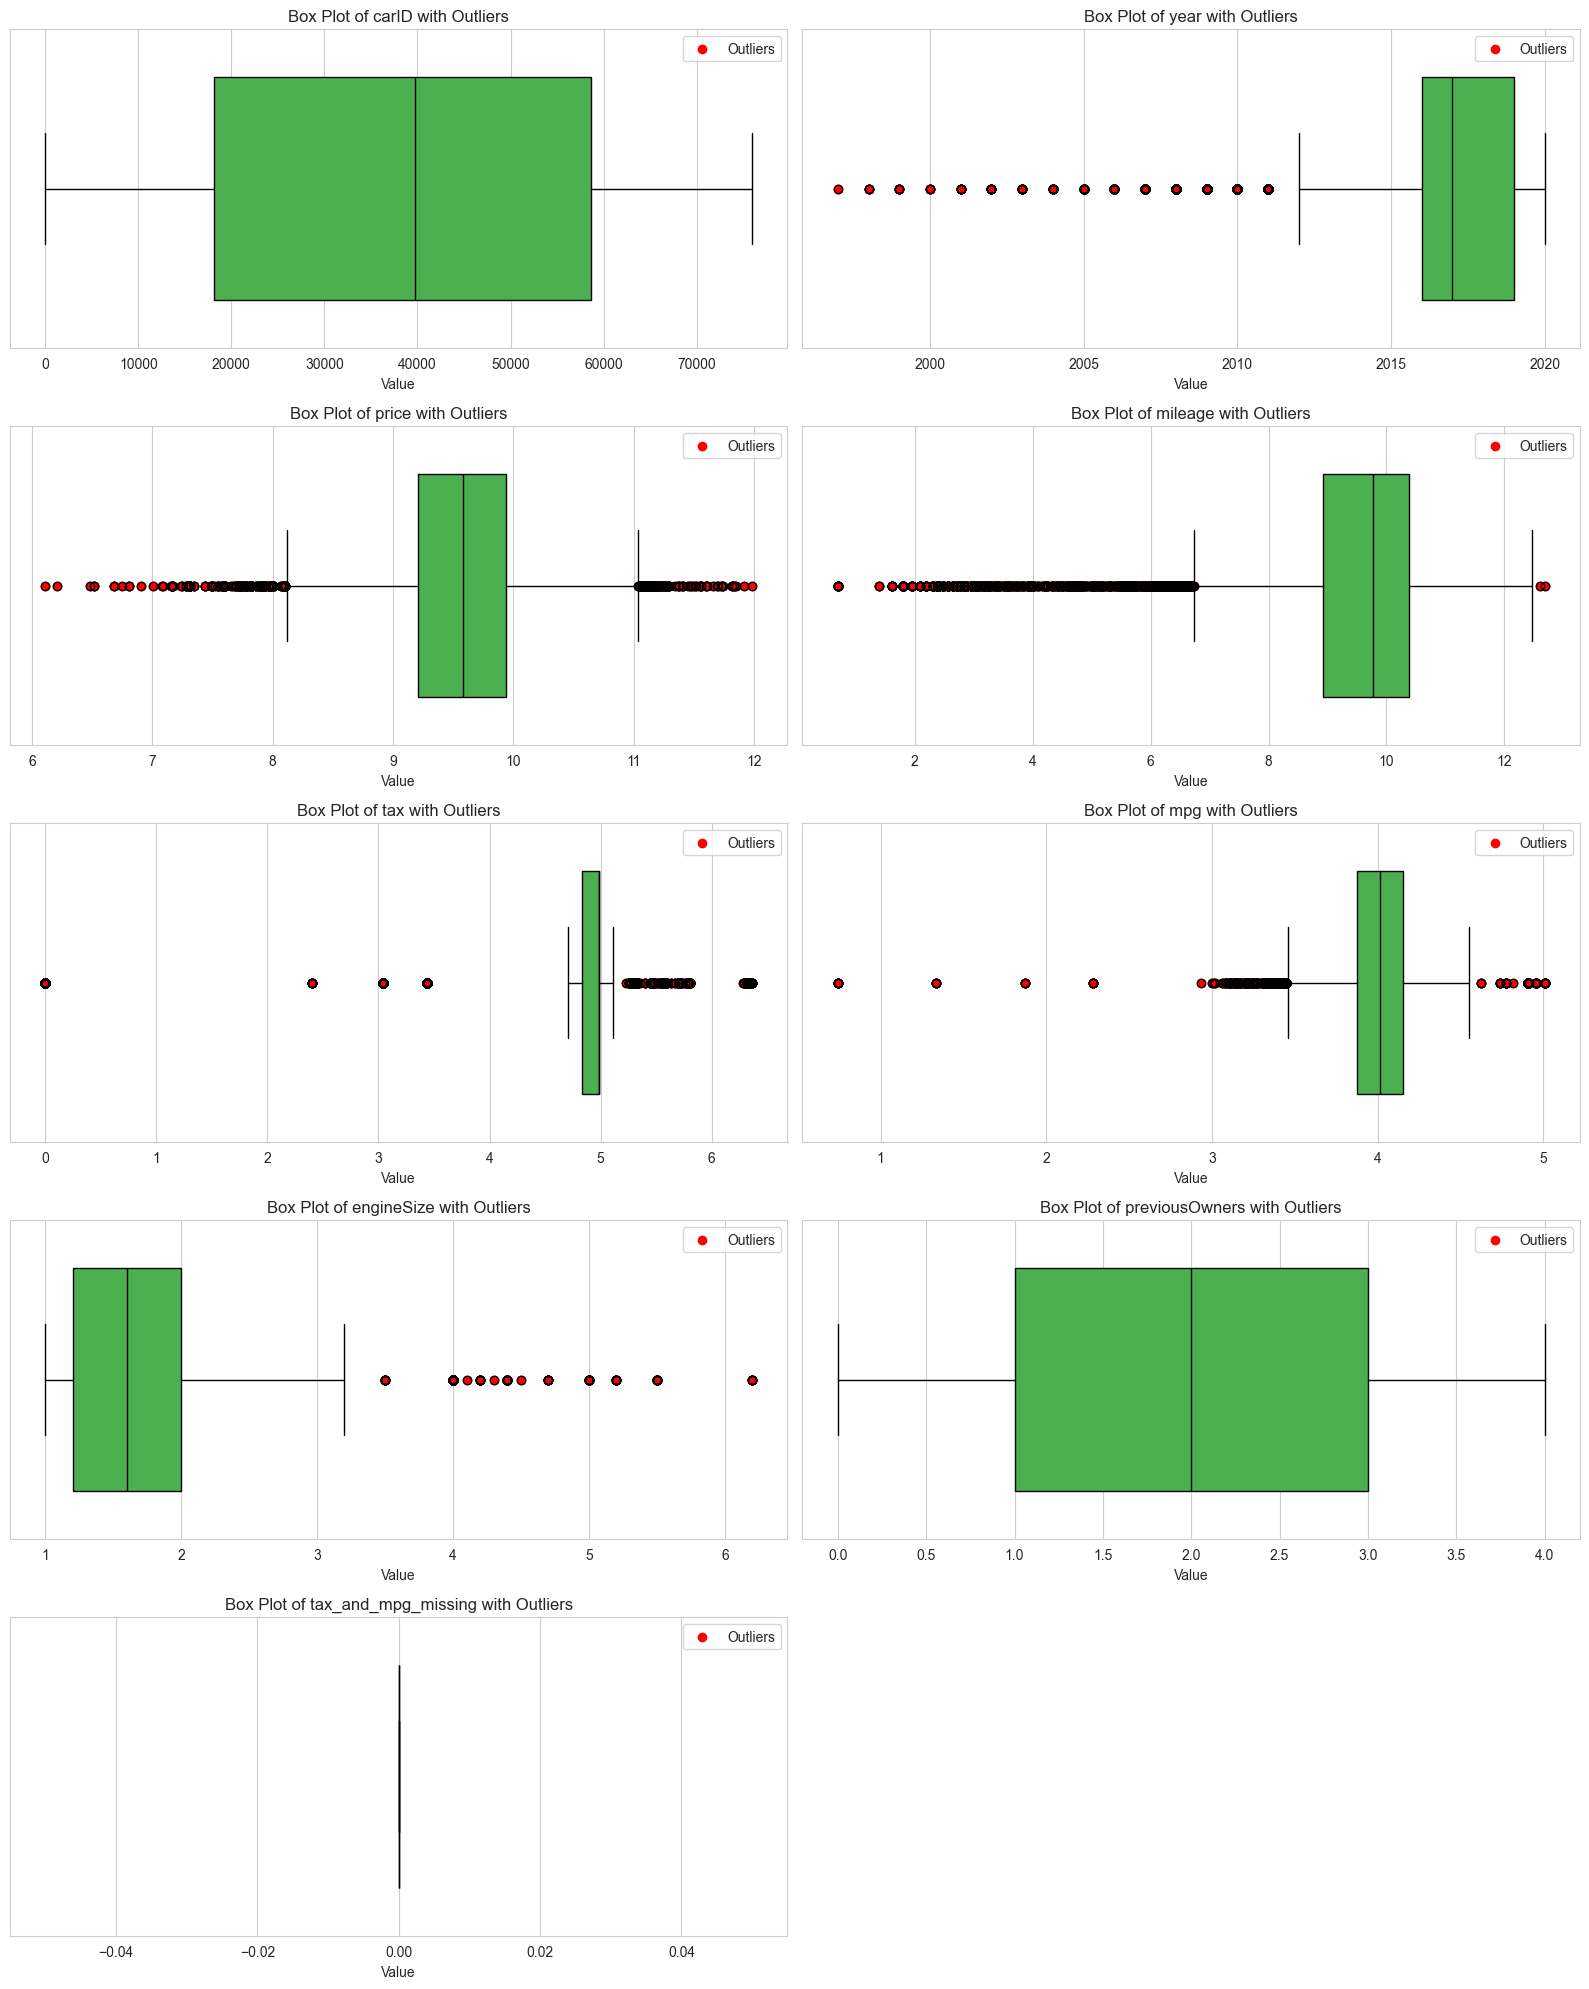

In [42]:
f.plot_multiple_boxes_with_outliers(train_set.dropna(), train_set_numerical)

### **Variable Relationships**

### Our goal here is to find the best relationship between variables so we can, more accuratly, fill the missing values

First we tried to find the relation between categorical variables using Cramér's V, but we realized that the variables might be directionally related

So we ended up going with a Theil's U directional relationship, while also testing out different variable combinations

In [43]:
cat_cols = train_set.select_dtypes(include=['object']).columns

# Compute Cramér's V between all pairs
for i, col1 in enumerate(cat_cols):
    for col2 in cat_cols[i+1:]:
        v = f.cramers_v(train_set[col1], train_set[col2])
        print(f"Cramér's V between {col1} and {col2}: {v:.3f}")

Cramér's V between Brand and model: 0.995
Cramér's V between Brand and transmission: 0.300
Cramér's V between Brand and fuelType: 0.278
Cramér's V between model and transmission: 0.366
Cramér's V between model and fuelType: 0.497
Cramér's V between transmission and fuelType: 0.197


In [44]:
num_cols = train_set.select_dtypes(include='number').drop(columns=['carID', 'price'], errors='ignore').columns

# Try single and multi-column combinations up to this size
max_combo_size = 3

print("\nTheil’s U directionally for Categorical Variables:")
for target in cat_cols:
    u_scores = {}
    
    for combo_size in range(1, max_combo_size + 1):
        for combo in combinations([c for c in cat_cols if c != target], combo_size):
            # Build a joint predictor variable by concatenating category values
            joint_name = " + ".join(combo)
            joint_var = train_set[list(combo)].astype(str).agg("_".join, axis=1)
            
            # Directional association: how much knowing combo tells about target
            u = f.theils_u(train_set[target], joint_var)
            u_scores[joint_name] = u

    # Pick top combinations that best explain target
    top3 = sorted(u_scores.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print(f"\nFor categorical column '{target}', best predictors:")
    for combo, u in top3:
        print(f"  U({target} | {combo}) = {u:.3f}")



Theil’s U directionally for Categorical Variables:

For categorical column 'Brand', best predictors:
  U(Brand | model + transmission + fuelType) = 0.982
  U(Brand | model + transmission) = 0.981
  U(Brand | model + fuelType) = 0.979

For categorical column 'model', best predictors:
  U(model | Brand + transmission + fuelType) = 0.563
  U(model | Brand + fuelType) = 0.538
  U(model | Brand + transmission) = 0.520

For categorical column 'transmission', best predictors:
  U(transmission | Brand + model + fuelType) = 0.330
  U(transmission | model + fuelType) = 0.319
  U(transmission | Brand + model) = 0.294

For categorical column 'fuelType', best predictors:
  U(fuelType | Brand + model + transmission) = 0.404
  U(fuelType | model + transmission) = 0.396
  U(fuelType | Brand + model) = 0.360


- We initially attempted to convert the numerical variables into categorical ones using binning so that they could be included in Theil's U calculation. However, this approach worsened the overall results, so we decided to focus solely on comparing the categorical variables.

We also explored the relationships between numerical target features and the possible combinations of numerical and categorical features. In this case, converting numerical features into bins and mixing them with categorical variables actually produced positive results.

In [45]:
for target in num_cols:
    scores = {}

    for num_paired in range(1, 3):  
        # Numeric predictor combinations
        for combo in combinations([c for c in num_cols if c != target], num_paired):
            df = train_set[list(combo) + [target]].dropna()
            if df.empty:
                continue
            model = LinearRegression().fit(df[list(combo)], df[target])
            scores[combo] = model.score(df[list(combo)], df[target])

        # Categorical predictor combinations
        for cat_combo in combinations(cat_cols, num_paired):
            combined = train_set[list(cat_combo)].astype(str).agg('_'.join, axis=1)
            scores[cat_combo] = f.correlation_ratio(combined, train_set[target]) ** 2

    # Mixed numeric + categorical pairs
    for num_col in [c for c in num_cols if c != target]:
        for cat_col in cat_cols:
            df = train_set[[num_col, cat_col, target]].dropna()
            if df.empty:
                continue
            # Discretize numeric variable into bins and combine with categorical
            numeric_bins = pd.cut(df[num_col], bins=60, duplicates='drop').astype(str)
            combined = df[cat_col].astype(str) + "_" + numeric_bins
            scores[(num_col, cat_col)] = f.correlation_ratio(combined, df[target]) ** 2

    # Top 3 helpers 
    top3 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"\nFor numerical column '{target}', top helpers (R² or η²):")
    for combo, score in top3:
        print(f" {combo} => {score:.3f}")


For numerical column 'year', top helpers (R² or η²):
 ('mileage', 'model') => 0.688
 ('mileage', 'fuelType') => 0.617
 ('tax', 'model') => 0.607

For numerical column 'mileage', top helpers (R² or η²):
 ('year', 'model') => 0.578
 ('year', 'Brand') => 0.541
 ('year', 'fuelType') => 0.526

For numerical column 'tax', top helpers (R² or η²):
 ('mpg', 'model') => 0.587
 ('year', 'model') => 0.517
 ('mpg', 'Brand') => 0.497

For numerical column 'mpg', top helpers (R² or η²):
 ('model', 'fuelType') => 0.663
 ('tax', 'model') => 0.583
 ('engineSize', 'fuelType') => 0.582

For numerical column 'engineSize', top helpers (R² or η²):
 ('mpg', 'model') => 0.892
 ('tax', 'model') => 0.773
 ('model', 'fuelType') => 0.723

For numerical column 'previousOwners', top helpers (R² or η²):
 ('mileage', 'model') => 0.075
 ('year', 'model') => 0.030
 ('mpg', 'model') => 0.026

For numerical column 'tax_and_mpg_missing', top helpers (R² or η²):
 ('tax',) => 1.000
 ('mpg',) => 1.000
 ('year', 'tax') => 1.0

### **Filling in missing values**

##### In order to impute in the missing values we will mainly use two functions "fill_NaN_with_categorical()" and "fill_NaN_with_mixed()"

##### They both work by imputing the mode of the helper categories, the only difference between them is that "fill_NaN_with_categorical()" only takes categorical helpers, while "fill_NaN_with_mixed()" can take both categorical and numeric variables

##### "fill_NaN_with_mixed()" works by converting numeric variables with bins, and imputing the mode

##### For the variables without any strong relationship with other variables, we fill them with their median or mode, depending on the variable's type

##### As a safety measure, in case any of the numeric columns's entry doesnt get filled, we fill them with their column's median

In [46]:
# Fill categorical columns
train_set = f.fill_NaN_with_categorical(train_set, "Brand", ["model","transmission","fuelType"])
train_set = f.fill_NaN_with_categorical(train_set, "Brand", ["model","transmission"]) # second best filling combination so we can best assure it gets filled 
train_set = f.fill_NaN_with_categorical(train_set, "model", ["Brand","transmission","fuelType"])
train_set = f.fill_NaN_with_categorical(train_set, "model", ["Brand","transmission"]) # second best filling combination so we can best assure it gets filled 
train_set = f.fill_NaN_with_categorical(train_set, "mpg", ["model","fuelType"])
train_set["transmission"] = train_set["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
train_set["fuelType"] = train_set["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


# Fill numeric columns with mixed helper approach
train_set = f.fill_NaN_with_mixed(train_set, "year", "model", "mileage")
train_set = f.fill_NaN_with_mixed(train_set,"mileage", "model", "year")
train_set = f.fill_NaN_with_mixed(train_set,"tax", "model", "year")
train_set = f.fill_NaN_with_mixed(train_set,"mpg", "model", "tax")
train_set = f.fill_NaN_with_mixed(train_set,"engineSize", "model", "tax")

train_set["previousOwners"] = (train_set["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64"))



# Fills any leftover missing values on numeric columns 
for col in num_cols:
    train_set[col] = train_set[col].astype(float)
    global_mean = train_set[col].median()
    train_set[col] = train_set[col].fillna(global_mean)
    if "Int64" in str(train_set[col].dtype):
        train_set[col] = train_set[col].round().astype("Int64")


In [47]:
# We do the same to val_set

# Fill categorical columns
val_set = f.fill_NaN_with_categorical(val_set, "Brand", ["model","transmission","fuelType"])
val_set = f.fill_NaN_with_categorical(val_set, "Brand", ["model","transmission"])  # second best filling combination so we can best assure it gets filled 
val_set = f.fill_NaN_with_categorical(val_set, "model", ["Brand","transmission","fuelType"])
val_set = f.fill_NaN_with_categorical(val_set, "model", ["Brand","transmission"])  # second best filling combination so we can best assure it gets filled 
val_set = f.fill_NaN_with_categorical(val_set, "mpg", ["model","fuelType"])
val_set["transmission"] = val_set["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
val_set["fuelType"] = val_set["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))


# Fill numeric columns with mixed helper approach
val_set = f.fill_NaN_with_mixed(val_set, "year", "model", "mileage")
val_set = f.fill_NaN_with_mixed(val_set, "mileage", "model", "year")
val_set = f.fill_NaN_with_mixed(val_set, "tax", "model", "year")
val_set = f.fill_NaN_with_mixed(val_set, "mpg", "model", "tax")
val_set = f.fill_NaN_with_mixed(val_set, "engineSize", "model", "tax")

val_set["previousOwners"] = (val_set["previousOwners"].transform(lambda x: x.fillna(x.median())).round().astype("Int64"))

# Fills any leftover missing values on numeric columns 
for col in num_cols:
    val_set[col] = val_set[col].astype(float)
    global_mean = train_set[col].median()
    val_set[col] = val_set[col].fillna(global_mean)
    if "Int64" in str(val_set[col].dtype):
        val_set[col] = val_set[col].round().astype("Int64")



In [48]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53181 entries, 11446 to 72173
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   carID                53181 non-null  int64  
 1   Brand                53181 non-null  object 
 2   model                53181 non-null  object 
 3   year                 53181 non-null  float64
 4   price                53181 non-null  float64
 5   transmission         53181 non-null  object 
 6   mileage              53181 non-null  float64
 7   fuelType             53181 non-null  object 
 8   tax                  53181 non-null  float64
 9   mpg                  53181 non-null  float64
 10  engineSize           53181 non-null  float64
 11  previousOwners       53181 non-null  float64
 12  tax_and_mpg_missing  53181 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 7.7+ MB


- Now no variable has missing values

### For ease of use we created a function called f.clean_data() that does everything we did before this

## **Actionables**

1. Data Splitting (Holdout Strategy)

Divide the data into training (70%) and validation (30%) sets before any cleaning to prevent data leakage and ensure the model is evaluated on unseen data.

2. Fixing variables

Drop columns that don't fit our goal.
Standardize letter casing and fix spelling errors in categorical features like Brand, model, transmission, and fuelType.
Convert data types (e.g., changing year and previousOwners from floats to integers).

3. Outlier treatment

Identify and treat physically impossible values, such as negative mileage, tax, or engineSize.
Address irrational numeric entries (e.g., numbers with excess decimal places where only 1-2 are realistic).
Use log to transform right skewed distributed variables so our model can better capture linear relationships.

4. Missing Value Treatment

Create a flag variable for features with correlated missingness on tax and mpg before filling them, so we can provide a way for our model to identify them.
Impute NaN values on every entry using averages from similar entries.

# **III. Regression Benchmarking**

## Performance Evaluation: Justification of Metrics

To quantify the effectiveness of the models developed for the **"Cars 4 You"** project, we selected two fundamental metrics: the **Coefficient of Determination ($R^2$)** and the **Mean Absolute Error (MAE)**.

The choice of these metrics is based on the need to balance the statistical interpretation of the model's fit with the practical and competitive requirements of the automotive market.

---

### 1. $R^2$ Score (Coefficient of Determination)
$R^2$ is used to measure the **explanatory power** of the model, indicating the proportion of the variance in car prices that is captured by the independent variables (such as year, mileage, brand, among others).

* **Global Fit:** In the context of this project, an $R^2$ value close to 1 demonstrates that the model successfully learned the fundamental patterns of the data.
* **Primary Indicator:** It serves as our main gauge for the algorithm's overall quality and regression fit.

### 2. MAE (Mean Absolute Error)
MAE was selected as our core error metric for two strategic reasons:

* **Consistency with the Kaggle Competition:**
    This is the official evaluation metric used by the Kaggle platform for this specific challenge. By focusing our optimization on MAE, we ensure a direct, fair, and transparent comparison with other competing models, aligning our final objective with the metric that determines the leaderboard rankings.

* **Business Interpretation and Transparency:**
    Unlike metrics such as MSE (which uses squared errors), MAE maintains the same unit as our target variable: **Euros**. This allows us to communicate results clearly to stakeholders; the MAE tells us exactly how many Euros, on average, our price predictions deviate from the actual market value. In the vehicle valuation business, this clarity is vital for making informed decisions regarding profit margins and competitive pricing.

### 3. Robustness and Final Selection
Additionally, we chose to prioritize MAE over metrics like RMSE due to its **robustness against outliers**.

Since MAE is less sensitive to these extreme deviations, it provides a more stable and realistic measure of the model's average performance in daily operations. This ensures that occasional, massive errors do not distort the overall perception of our solution's effectiveness.

## **Feature Engineering**

### In this sections we aim to create new features that will improve our model's results

In [49]:
# Previously we added a flag that marked every entry that had both tax and mpg missing, due to their missing value's correlation
# train_set['tax_and_mpg_missing'] = (train_set['tax'].isna() & train_set['mpg'].isna()).astype(int)
# It had to be done before this section due to its nature, it could only be added before the missing values were filled

In [50]:
# We figured that these two variables could work really well toghether
# A car that has a really high mileage and a really high mpg would probably be a car that does long highway trips, which would lead to less damage per mile compared 
#to a car that only does short trips
# A car with low mileage and low mpg could be something like a sports car, or a weekend car
train_set['mileage_mpg_conj'] = train_set['mileage'] * train_set['mpg']
val_set['mileage_mpg_conj'] = val_set['mileage'] * val_set['mpg']

We need to encode categorical variables into numericals. We decided to encode Brand transmission and fuelType with one-hot encoding, and created a Brand_model_encoded where,  we can convert the model column to numeric, by using target encoding, without having to worry about different brands having models with the same name

In [51]:
# We combine the sets back toghether so we can properly encode them
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)
combined_temp['fuelType'] = combined_temp['fuelType'].replace('other', 'electric')
combined_temp['transmission'] = combined_temp['transmission'].replace('other', 'unknown')
combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)


# Seperate them again
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()

In [52]:
# We do this after separating the two sets again, to make sure none of the val_set's data influences the encoding

# Target Encoding 
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Apply that to train
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Same goes for validation
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)



## **Feature Selection**

First we decided to use a filter method to quickly check every variables correlation with the target and with other variables, here we used the Spearman method given the lack of linearity of the relationships between our target and variables

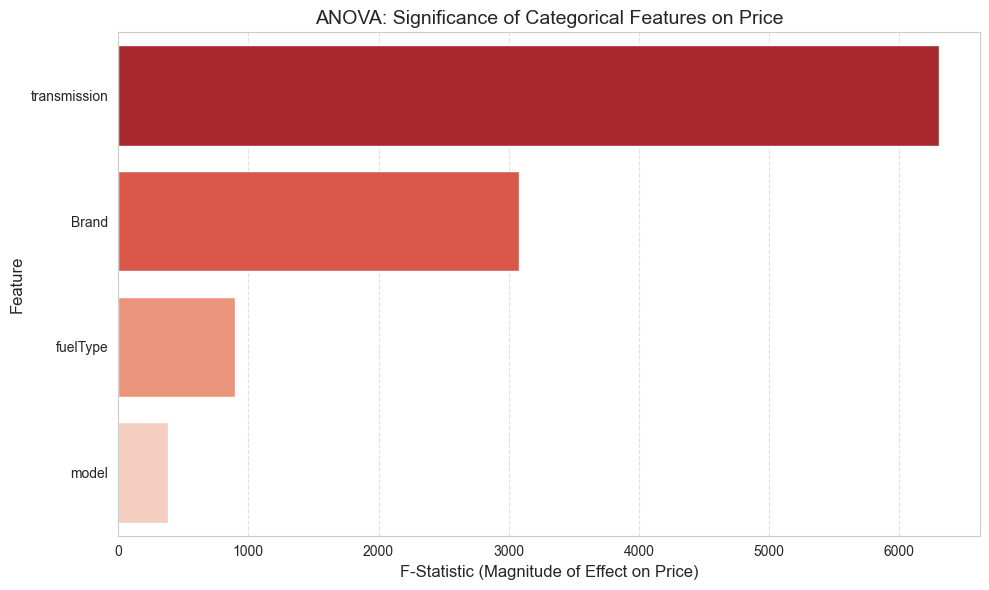

In [53]:
f_scores = {}
for col in cat_cols:
    # Group price by the categorical levels and drop NaNs
    df_sub = train_set[[col, 'price']].dropna()
    groups = [group['price'].values for name, group in df_sub.groupby(col)]
    
    # perform one-way ANOVA
    f_stat, p_val = stats.f_oneway(*groups)
    f_scores[col] = f_stat

# Convert to a sorted series for plotting
anova_series = pd.Series(f_scores).sort_values(ascending=False)

# Significance Graph
plt.figure(figsize=(10, 6))
sns.barplot(x=anova_series.values, y=anova_series.index, palette='Reds_r')

plt.title('ANOVA: Significance of Categorical Features on Price', fontsize=14)
plt.xlabel('F-Statistic (Magnitude of Effect on Price)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



- Model has a really low F score, most likely because of its volume of categories

Checking the numerical variables correlation with the target

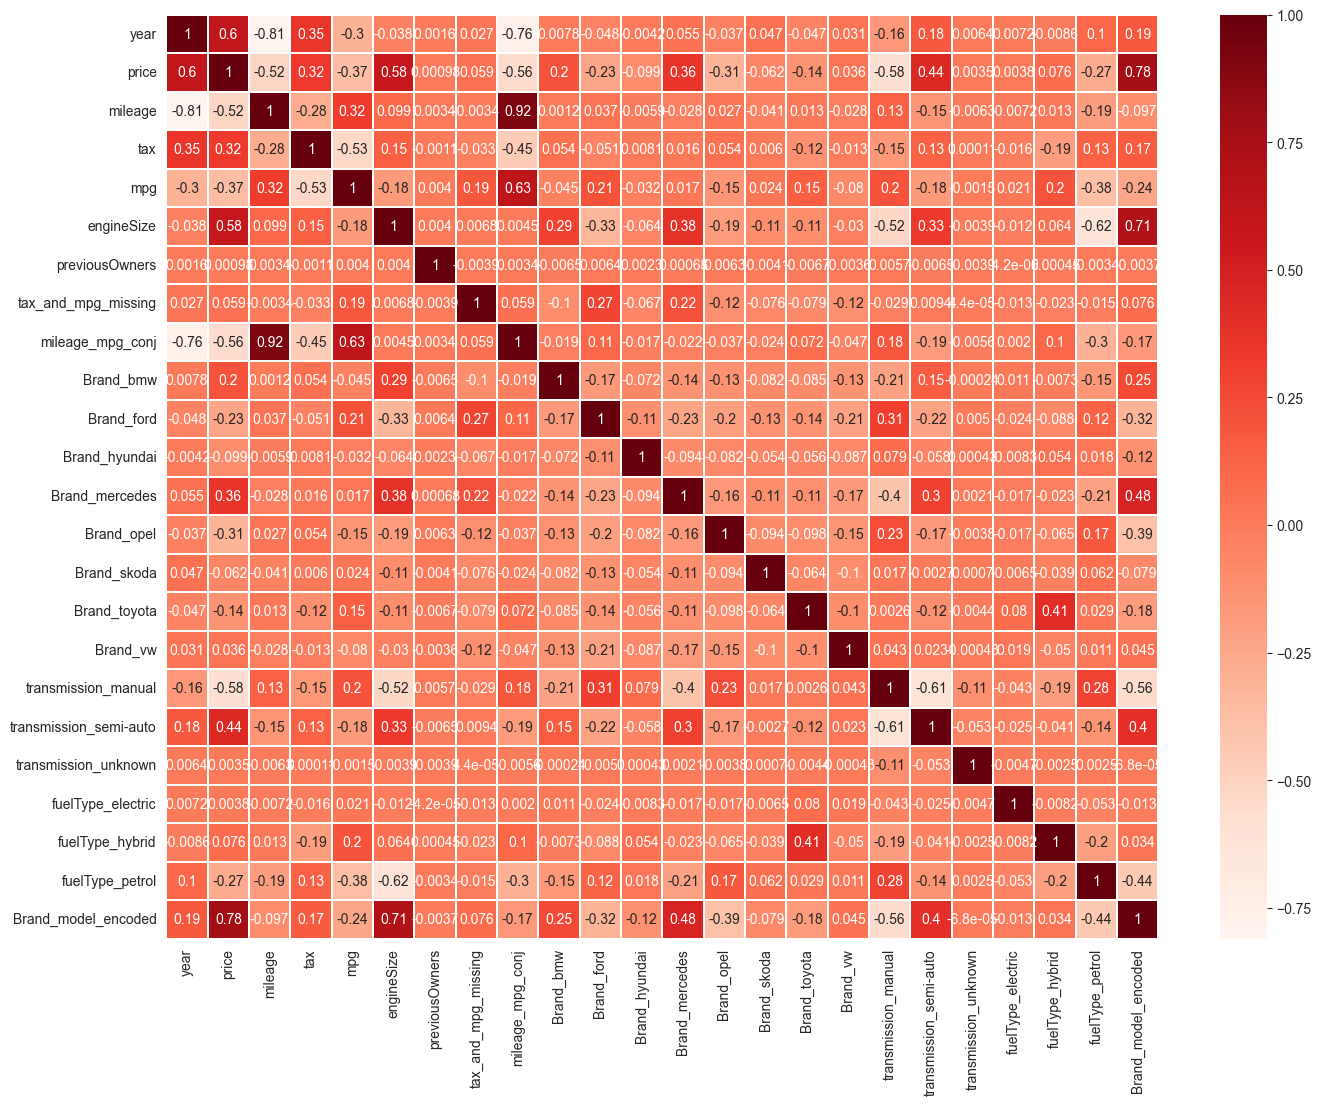

In [54]:
# Remove rows with missing values
temp = train_set_encoded.copy()

temp = temp.drop(columns=['carID','model'])

# Select numerical columns for correlation analysis
corr_data = temp.select_dtypes(include=["number"])

# Compute the Pearson correlation matrix
correlation_matrix = temp.corr(method="spearman")

# Plot the correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap = plt.cm.Reds, linewidths=0.1)
plt.show()

- year and mileage have a strong relationship
- and so does tax and mpg
- tax_and_mpg_missing doesn't correlate with the target
- mileage_mpg_conj has a good realtionship with target, but it correlates to heavily with other features whilst having a worse correlation than mileage with target
- year, mileage and engineSize have a strong correlation with the target
- carID, paintQuality% and previousOwners seem to have little correlation with any variable
- Brand_model_encoded has the best correlation with target, but that might be linked with it being target encoded, it also has a high correlation with engine size
- transmission_manual and fuelType_petrol have a high negative correlation with price
- fuelType_petrol and engineSize have a strong relationship



Next we divide our datasets into X(non target columns) and Y(target column) while also removing columns that are irrelevant to the feature selection ("carID","model")

And then we scale our Xs using MinMaxScaler() in order to bring all features into the same range, improving model convergence and ensuring that no single feature dominates due to its scale

We use MinMaxScaler() to avoid having negative values in our scale, so it doesn't interfere with our NN

In [55]:
drop_cols = ["price", "carID", "model"]

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]


scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

X_train_scaled

,year,mileage,tax,mpg,engineSize,previousOwners,tax_and_mpg_missing,mileage_mpg_conj,Brand_bmw,Brand_ford,...,Brand_skoda,Brand_toyota,Brand_vw,transmission_manual,transmission_semi-auto,transmission_unknown,fuelType_electric,fuelType_hybrid,fuelType_petrol,Brand_model_encoded
11446,0.833333,0.772764,0.899263,0.679893,0.384615,0.75,0.0,0.609065,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.653751
42107,0.833333,0.903365,0.478341,0.827141,0.115385,0.75,0.0,0.840076,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.564087
42568,0.791667,0.828706,0.759854,0.766597,0.038462,1.00,0.0,0.722843,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.467684
56466,0.958333,0.705956,0.783001,0.676805,0.192308,0.00,0.0,0.554836,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.783336
41646,0.833333,0.797284,0.837091,0.695326,0.192308,0.25,0.0,0.640225,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.579254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44295,0.958333,0.656111,0.783001,0.789973,0.000000,0.25,0.0,0.589884,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.524029
33867,0.958333,0.649263,0.783001,0.653969,0.384615,0.00,0.0,0.496065,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.809032
31019,0.708333,0.881991,0.798367,0.753972,0.192308,0.75,0.0,0.757763,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.627488
44566,1.000000,0.708010,0.783001,0.662713,0.384615,0.75,0.0,0.546579,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.728412


Next we wanted to calculate the optimal number of features using a wrapper method, so we picked RFE (with linear regression) to rank every features importance acording to the model's performance, to decide the optimal number of features we decided to pick both AIC/BIC and Adjusted RSquared as our metrics

In [56]:
nof_list = np.arange(1, len(X_train_scaled.columns) + 1)
results = []
n_samples = X_train_scaled.shape[0]

print(f"{'Features':<10} | {'AIC':<12} | {'BIC':<12} | {'Adj. R2':<10}")
print("-" * 55)

for n in nof_list:
    model = LinearRegression()
    rfe = RFE(estimator=model, n_features_to_select=n)
    

    X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)
    
    # Fit model
    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_train_rfe)
    
    # Calculate metrics
    mse = mean_squared_error(y_train, y_pred)
    sse = mse * n_samples
    r2 = model.score(X_train_rfe, y_train)
    
    # k is number of features + 1 (for the intercept)
    k = n + 1
    
    # AIC and BIC formulas
    aic = n_samples * np.log(sse / n_samples) + 2 * k
    bic = n_samples * np.log(sse / n_samples) + k * np.log(n_samples)
    
    # Adjusted R2
    adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n - 1)
    
    results.append({
        'n': n,
        'aic': aic,
        'bic': bic,
        'adj_r2': adj_r2,
    })
    
    print(f"{n:<10} | {aic:<12.2f} | {bic:<12.2f} | {adj_r2:<10.4f}")

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Best scores
best_nof_aic = df_results.loc[df_results['aic'].idxmin(), 'n']
best_nof_bic = df_results.loc[df_results['bic'].idxmin(), 'n']
best_nof_adjr2 = df_results.loc[df_results['adj_r2'].idxmax(), 'n']


print("-" * 65)
print(f"Optimal features (AIC):    {best_nof_aic}")
print(f"Optimal features (BIC):    {best_nof_bic}")
print(f"Optimal features (AdjR2): {best_nof_adjr2}")


Features   | AIC          | BIC          | Adj. R2   
-------------------------------------------------------
1          | -113420.92   | -113403.15   | 0.5796    
2          | -165932.02   | -165905.37   | 0.8434    
3          | -179491.87   | -179456.35   | 0.8786    
4          | -183386.99   | -183342.58   | 0.8872    
5          | -183517.75   | -183464.46   | 0.8875    
6          | -183735.35   | -183673.18   | 0.8880    
7          | -185264.61   | -185193.55   | 0.8911    
8          | -188977.12   | -188897.18   | 0.8985    
9          | -190760.73   | -190671.91   | 0.9018    
10         | -191266.62   | -191168.93   | 0.9028    
11         | -192045.44   | -191938.86   | 0.9042    
12         | -192944.17   | -192828.71   | 0.9058    
13         | -192978.93   | -192854.59   | 0.9058    
14         | -193058.09   | -192924.87   | 0.9060    
15         | -193144.65   | -193002.54   | 0.9061    
16         | -193341.88   | -193190.90   | 0.9065    
17         | -193687.06   

We will be using 22 features here

In [57]:
model = LinearRegression()

rfe = RFE(estimator = model, n_features_to_select = 22)

train_set_rfe = rfe.fit_transform(X = X_train_scaled, y = y_train)

rfe.support_

array([ True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [58]:
X_train_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'previousOwners',
       'tax_and_mpg_missing', 'mileage_mpg_conj', 'Brand_bmw', 'Brand_ford',
       'Brand_hyundai', 'Brand_mercedes', 'Brand_opel', 'Brand_skoda',
       'Brand_toyota', 'Brand_vw', 'transmission_manual',
       'transmission_semi-auto', 'transmission_unknown', 'fuelType_electric',
       'fuelType_hybrid', 'fuelType_petrol', 'Brand_model_encoded'],
      dtype='object')

In [59]:
rfe.ranking_

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [60]:
selected_features = pd.Series(rfe.support_, index = X_train_scaled.columns)
selected_features

year                       True
mileage                    True
tax                        True
mpg                        True
engineSize                 True
previousOwners            False
tax_and_mpg_missing        True
mileage_mpg_conj           True
Brand_bmw                  True
Brand_ford                 True
Brand_hyundai              True
Brand_mercedes             True
Brand_opel                 True
Brand_skoda                True
Brand_toyota               True
Brand_vw                   True
transmission_manual        True
transmission_semi-auto     True
transmission_unknown       True
fuelType_electric          True
fuelType_hybrid            True
fuelType_petrol            True
Brand_model_encoded        True
dtype: bool

The RFE only rejected the previousOwners feature

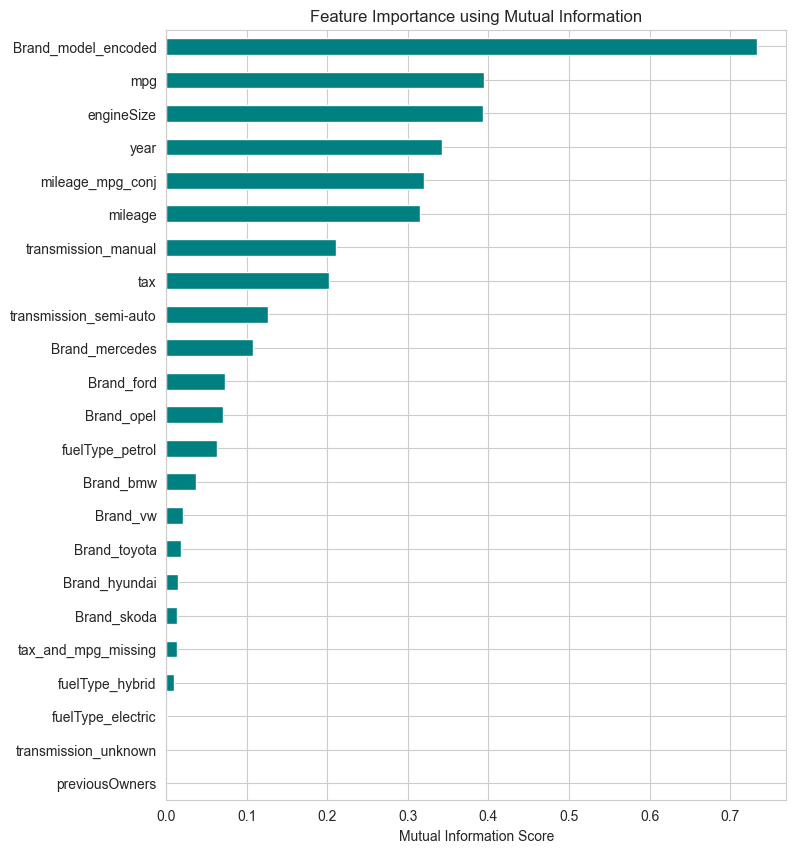

In [61]:


# Calculate Mutual Information scores
mi_scores = mutual_info_regression(X_train_scaled, y_train, random_state=2)

# Organize into a Series for easy plotting
mi_series = pd.Series(mi_scores, index=X_train_scaled.columns)
mi_series = mi_series.sort_values(ascending=True)

# Plot the importance
def plot_mi_importance(scores):
    plt.figure(figsize=(8, 10))
    scores.plot(kind="barh", color="teal")
    plt.title("Feature Importance using Mutual Information")
    plt.xlabel("Mutual Information Score")
    plt.show()

plot_mi_importance(mi_series)


- fuelType_eletric, transmission_unknown and previousOwners got rejeced by the mutual information score

Next we checked the features's importance with an embeded method, the LASSO, in orther to better and more confidently identify features with minimal predictive contribuition

In [62]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()


reg.fit(X_train_scaled, y_train)

coef = pd.Series(reg.coef_, index = X_train_scaled.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 21 variables and eliminated the other 2 variables


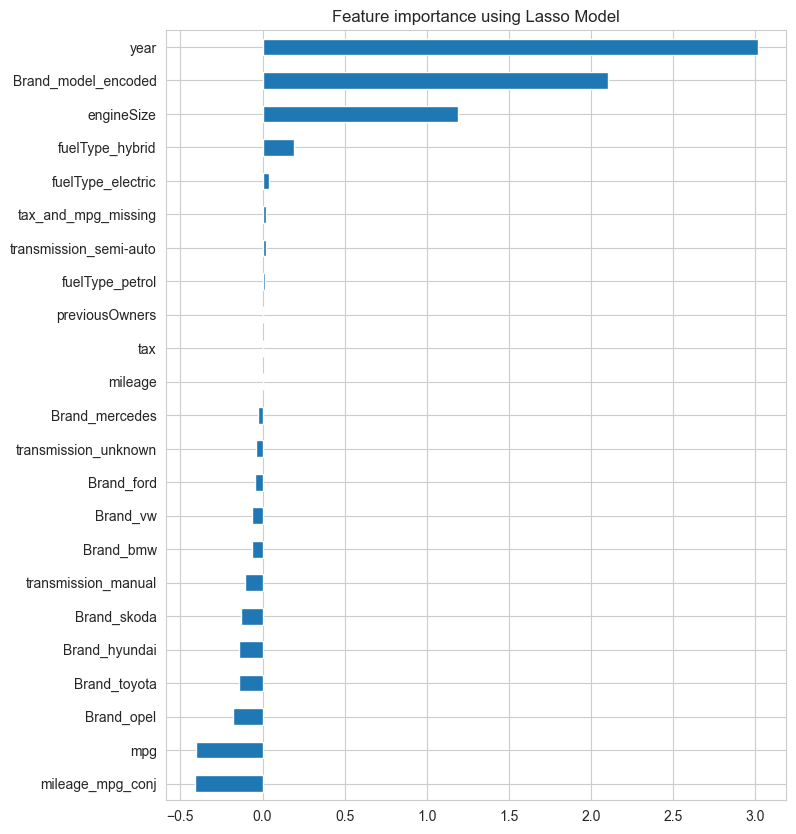

In [63]:
plot_importance(coef,'Lasso')

| Predictor                  | Pearson | RFE (LR) | Lasso  | Mutual Info | What to do? (One possible way to "solve") | Final decision |
|----------------------------|---------|----------|--------|-------------|------------------------------------------|----------------|
| Brand_model_encoded        | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| year                       | Keep?   | Keep     | Keep   | Keep        | Include                                  | Include        |
| engineSize                 | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| tax                        | Keep?   | Discard? | Keep   | Keep        | Try with and without                     | Include        |
| previousOwners             | Keep?   | Discard  | Discard| Discard     | Discard                                  | Discard        |
| mpg                        | Keep?   | Keep     | Keep?  | Keep        | Try with and without                     | Include        |
| mileage                    | Keep?   | Keep     | Keep?  | Keep        | Try with and without                     | Include        |
| mileage_mpg_conj           | Discard | Keep     | Keep   | Keep        | Try with and without                     | Discard        |
| tax_and_mpg_missing        | Discard | Keep     | Keep?  | Keep        | Try with and without                     | Discard        |
| transmission_manual        | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| transmission_semi-auto     | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| transmission_unknown       | Keep?   | Keep     | Keep   | Discard     | Include                                  | Include        |
| Brand_hyundai              | Keep?   | Keep     | Keep   | Keep        | Include                                  | Include        |
| Brand_skoda                | Keep?   | Keep     | Keep   | Keep        | Include                                  | Include        |
| Brand_mercedes             | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| Brand_ford                 | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| Brand_opel                 | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| Brand_bmw                  | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| Brand_vw                   | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| Brand_toyota               | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| fuelType_petrol            | Keep    | Keep     | Keep   | Keep        | Include                                  | Include        |
| fuelType_hybrid            | Keep?   | Keep     | Keep   | Keep        | Include                                  | Include        |
| fuelType_electric          | Keep?   | Keep     | Keep   | Discard     | Include                                  | Include        |



<hr>


### Categorical Data

| Predictor     | ANOVA |
|---------------|-------|
| Brand         | Keep  |
| model         | Keep? |
| transmission  | Keep  |
| fuelType      | Keep  |



<hr>


After testing out different combinations, we came to the conclusion that dropping previousOwners had the best result

In [64]:
X_train_scaled = X_train_scaled.drop(columns=['previousOwners','tax_and_mpg_missing','mileage_mpg_conj'])

X_val_scaled = X_val_scaled.drop(columns=['previousOwners','tax_and_mpg_missing','mileage_mpg_conj'])

# Predictive Modeling

In this step, we implement a robust data preparation pipeline focused on preventing **Data Leakage**:

1.  **Holdout Split:** Immediate separation of data into Train (70%) and Validation (30%).
2.  **Feature Engineering:** Application of *One-Hot* and *Target Encoding* (calculated strictly on the training set and applied to validation).
3.  **Scaling:** Data normalization (MinMax) to ensure consistency across variables.
4.  **Predefined Split:** Recombining processed data into a specific structure that forces `RandomizedSearchCV` to validate strictly on our holdout set, rather than creating random folds.

In [65]:
# Load Data
train_db = pd.read_csv("./train.csv")
# Important: Apply log to the target right at the start (if that is the strategy)
train_db['price'] = np.log1p(train_db['price'])

# HOLDOUT SPLIT (Initial Split)
# Here we ensure that validation data never sees the training data
train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

# Independent Cleaning (Clean Data)
train_set = f.clean_data(train_set)
val_set = f.clean_data(val_set)

# ENCODING & SCALING (Where Data Leakage occurs if not careful)

# One-Hot Encoding
# We must ensure columns match. We concatenate just to generate dummies, then separate again.
train_len = len(train_set)
combined_temp = pd.concat([train_set, val_set], axis=0)

combined_temp = pd.get_dummies(combined_temp, columns=["Brand", "transmission", "fuelType"], drop_first=True)

# Split back to Train and Validation
train_set_encoded = combined_temp.iloc[:train_len].copy()
val_set_encoded = combined_temp.iloc[train_len:].copy()

# Target Encoding (FIT on Train, TRANSFORM on Train and Validation)
# Calculate means on Train
mapping = train_set.groupby(["Brand", "model"])["price"].mean().to_dict()
global_mean = train_set["price"].mean()

# Apply to Train
train_set_encoded["Brand_model_encoded"] = train_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# Apply to Validation (using the training mapping!)
val_set_encoded["Brand_model_encoded"] = val_set.apply(
    lambda x: mapping.get((x["Brand"], x["model"]), global_mean), axis=1
)

# FINAL PREPARATION (X and y)
drop_cols = ["price", "carID", "model", "previousOwners"] # Columns to remove

X_train = train_set_encoded.drop(columns=drop_cols, errors='ignore')
y_train = train_set_encoded["price"]

X_val = val_set_encoded.drop(columns=drop_cols, errors='ignore')
y_val = val_set_encoded["price"]

# Scaling (FIT on Train, TRANSFORM on both)
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)

### Concatenation & Predefined Split 
To use RandomizedSearchCV with our specific **holdout** data, we concatenate the processed sets and create a PredefinedSplit. A mask (-1 for train, 0 for validation) forces the algorithm to validate strictly on our **holdout** set rather than using random cross-validation.

In [66]:
# Combine processed data (Reset index to ensure alignment)
X_combined = pd.concat([X_train_scaled, X_val_scaled], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# Create the Split "Mask" (test_fold)
# -1 indicates: "This sample is for training, use it to learn"
#  0 indicates: "This sample is for validation, use it to test" (0 is the index of the validation fold)

# Array with -1 for the length of the training set
split_index_train = [-1] * len(X_train_scaled)
# Array with 0 for the length of the validation set
split_index_val = [0] * len(X_val_scaled)

# Combine the two lists
test_fold = split_index_train + split_index_val

# Create the PredefinedSplit Object
ps = PredefinedSplit(test_fold=test_fold)

# Linear Regression

`Manual Splitting`: Since there are no hyperparameters to tune, we bypass RandomizedSearchCV and manually filter the data using the ps.test_fold indices (-1 for Train, 0 for Validation). This guarantees the exact same data split as the advanced models for a fair comparison.

`Log-Space Training`: The model is trained on price_log to handle the right-skewed distribution of car prices, preventing luxury outliers from distorting the "line of best fit." We revert this using np.expm1 to calculate the final MAE in Euros.

In [67]:
# 1. Filter data manually (since we are not using RandomizedSearchCV here)
# ps.test_fold contains -1 (train) and 0 (validation)
X_train_lr = X_combined.iloc[[i for i, x in enumerate(ps.test_fold) if x == -1]]
y_train_lr = y_combined.iloc[[i for i, x in enumerate(ps.test_fold) if x == -1]]

X_val_lr = X_combined.iloc[[i for i, x in enumerate(ps.test_fold) if x == 0]]
y_val_lr = y_combined.iloc[[i for i, x in enumerate(ps.test_fold) if x == 0]]

# 2. Train
lr_model = LinearRegression(n_jobs=-1)
print("Training Simple Linear Regression...")
lr_model.fit(X_train_lr, y_train_lr)

# 3. Predict (Log Scale)
y_pred_log = lr_model.predict(X_val_lr)

# --- TECHNICAL EVALUATION (Log Scale) ---
mae_log = mean_absolute_error(y_val_lr, y_pred_log)
r2_log = r2_score(y_val_lr, y_pred_log)

print(f"\n--- Technical Metrics (Log Scale) ---")
print(f"MAE (log):  {mae_log:.4f}")
print(f"R2 (log):   {r2_log:.4f}")

# --- BUSINESS EVALUATION (Real Euros) ---
# Important: Invert log transformation (np.expm1) to see error in real money
y_val_real = np.expm1(y_val_lr)
y_pred_real = np.expm1(y_pred_log)

mae_real = mean_absolute_error(y_val_real, y_pred_real)
r2_real = r2_score(y_val_real, y_pred_real)

print(f"\n--- Business Metrics (Real Euros) ---")
print(f"MAE:  €{mae_real:.2f}")
print(f"R2:   {r2_real:.4f}")

Training Simple Linear Regression...

--- Technical Metrics (Log Scale) ---
MAE (log):  0.1214
R2 (log):   0.9053

--- Business Metrics (Real Euros) ---
MAE:  €2026.59
R2:   0.8852


In [144]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(lr_model, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "LR")



==================== EVALUATION: LR ====================
MAE Train:      € 2,012.38
MAE Validation: € 2,026.59
R2 Score:       0.8852
Overfit Gap:    0.71%


No significant overfit

# KNN Bagging (K-Nearest Neighbors)

### Hyperparameter Tuning (KNN Bagging)

We employ an advanced ensemble technique by wrapping K-Nearest Neighbors (KNN) inside a Bagging Regressor.

`Rationale`: Standard KNN is a "high variance" algorithm—it can be very sensitive to noisy outliers and irrelevant features. By training multiple KNN models on random subsets of data and averaging their predictions, Bagging drastically improves robustness and generalization.

`Nested Tuning (estimator__)`: We perform a "Hybrid" search. We tune the Macroscopic parameters (how the ensemble is built) simultaneously with the Microscopic parameters of the internal KNN models.

Ensemble Parameters (The Wrapper):

`n_estimators`: We test between 10 and 100 independent KNN models. More estimators generally lead to smoother decision boundaries and more stable predictions.

`max_samples`: This controls the size of the random subset of rows fed to each KNN (e.g., 0.5 = 50% of data). Lower values increase diversity among the models, which is the key to reducing overfitting.

`max_features`: We force each KNN to look at only a random subset of columns (70% to 100%). This prevents all models from relying on the exact same dominant features, effectively decorrelating the ensemble.

Internal KNN Parameters (The Estimator):

`estimator__n_neighbors`: The core 'k' parameter (3 to 40). We test low values (capturing local details) against high values (capturing global trends).

`estimator__weights`: We compare uniform (all neighbors vote equally) vs. distance (closer neighbors have more influence). For price prediction, distance is often superior as identical cars should weigh more than merely "similar" ones.

`estimator__metric` & `estimator__p`: We optimize the distance calculation method.

- p=1 (Manhattan): Sum of absolute differences. Often performs better in high-dimensional spaces (like One-Hot Encoded data).

- p=2 (Euclidean): Straight-line distance. The standard geometric metric.

In [ ]:
# Setting up RandomizedSearchCV using the predefined split (ps)
# We are testing a Bagging approach with KNN as the base learner
knn_base = KNeighborsRegressor()
bagging_knn = BaggingRegressor(estimator=knn_base, random_state=42)

# Defining the specific metrics we want to track during the search
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# Hyperparameter grid based on the Bagging-KNN setup
param_dist = {
    # Bagging specific settings
    'n_estimators': [10, 30, 50, 100], 
    'max_samples': [0.5, 0.7, 0.8, 1.0],
    'max_features': [0.7, 0.8, 0.9, 1.0],
    
    # Internal KNN settings (using the estimator__ prefix)
    'estimator__n_neighbors': randint(3, 40),
    'estimator__weights': ['distance', 'uniform'],
    'estimator__metric': ['manhattan', 'euclidean'],
    'estimator__p': [1, 2]
}

# param_dist = {
#     # Bagging specific settings
#     'n_estimators': [100], 
#     'max_samples': [1.0],
#     'max_features': [0.8],
    
#     # Internal KNN settings
#     'estimator__n_neighbors': [11],
#     'estimator__weights': ['distance'],
#     'estimator__metric': ['euclidean'],
#     'estimator__p': [2]
# }

random_search = RandomizedSearchCV(
    estimator=bagging_knn,
    param_distributions=param_dist,
    n_iter=30,             # Number of random combinations to try
    cv=ps,                 # Using our custom validation split
    scoring=scoring_metrics,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit="MAE"            # The search will prioritize the best MAE score
)

# Kicking off the optimization process
print("Starting the optimization focused purely on MAE (Bagging KNN)...")
# Note: X_combined needs to be scaled beforehand since KNN is distance-based
random_search.fit(X_combined, y_combined)

# Reviewing the best results
# best_score_ will return the performance of the metric we chose in 'refit'
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Top MAE (log scale): {-random_search.best_score_:.4f}") 

# Checking the R2 score just for extra context
results = random_search.cv_results_
best_index = random_search.best_index_
r2_score_val = results['mean_test_R2'][best_index]

print(f"Corresponding R2 Score: {r2_score_val:.4f}")

# The best estimator is already trained on the full dataset and ready to go
best_bagging_knn = random_search.best_estimator_

print("\n--- Real-World Performance (Validation Set) ---")

# ps.test_fold has -1 for training and 0 for validation
train_indices = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_only = X_combined.iloc[train_indices]
y_train_only = y_combined.iloc[train_indices]

# 2. Isolate Validation data
val_indices = [i for i, x in enumerate(ps.test_fold) if x == 0]
X_val = X_combined.iloc[val_indices]
y_val_log = y_combined.iloc[val_indices]

# 3. Create a NEW model with Best Parameters
# IMPORTANT: Here we define KNeighborsRegressor as the base
base_est = KNeighborsRegressor() 

model_for_val = BaggingRegressor(estimator=base_est, random_state=42)
model_for_val.set_params(**random_search.best_params_)

# 4. Train ONLY on training set (without seeing validation)
model_for_val.fit(X_train_only, y_train_only)

# 5. Predict on Validation
preds_log = model_for_val.predict(X_val)

# 6. Convert and Calculate Real Metrics
y_pred_euros = np.expm1(preds_log)
y_true_euros = np.expm1(y_val_log)

real_mae = mean_absolute_error(y_true_euros, y_pred_euros)
real_r2 = r2_score(y_true_euros, y_pred_euros)

print(f"Real MAE:  € {real_mae:.2f}")
print(f"Real R2:     {real_r2:.4f}")

Starting the optimization focused purely on MAE (Bagging KNN)...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters found: {'n_estimators': 100, 'max_samples': 1.0, 'max_features': 0.8, 'estimator__weights': 'distance', 'estimator__p': 2, 'estimator__n_neighbors': 11, 'estimator__metric': 'euclidean'}
Top MAE (log scale): 0.0839
Corresponding R2 Score: 0.9467

--- Real-World Performance (Validation Set) ---
Real MAE:  € 1411.87
Real R2:     0.9307


In [179]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(model_for_val, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "Bagging KNN")



==================== EVALUATION: BAGGING KNN ====================
MAE Train:      € 635.17
MAE Validation: € 1,411.87
R2 Score:       0.9307
Overfit Gap:    122.28%


Large significant overfit

# Random Forest

### Hyperparameter Tuning (Random Forest)

We optimize the Random Forest Regressor, a robust ensemble method that reduces overfitting by averaging predictions from hundreds of independent decision trees.

`Search Strategy`: We utilize RandomizedSearchCV instead of Grid Search. This allows us to sample a wide range of distributions efficiently without the computational cost of testing every single combination.

`cv=ps (Predefined Split)`: This is the critical component. Instead of standard K-Fold cross-validation (which might shuffle data inappropriately), we pass our custom PredefinedSplit. This forces the search to train strictly on the training set and score strictly on the validation set, ensuring zero data leakage.

Key Hyperparameters:

`n_estimators (500-3000)`: We test a high number of trees to ensure convergence and stability.

`max_depth`: We limit the depth (e.g., 15-30) to prevent individual trees from memorizing noise in the training data.

`min_samples_leaf`: By requiring leaves to contain multiple samples (1-10), we force the model to generalize rather than fit to outliers.

`criterion`: "squared_error" for the mean squared error, and not “absolute_error” because is significantly slower than when using “squared_error”.

In [ ]:
# Setting up RandomizedSearchCV using our predefined split (ps)
# We're going with a Random Forest Regressor for this run
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# I'm focusing specifically on these two metrics.
# We've decided to drop RMSE to keep the evaluation cleaner.
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

#SDefining the range for our hyperparameter search
param_dist = {
    'n_estimators': randint(500, 3000),
    'max_depth': [None, 15, 20, 25, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
}

# param_dist = {
#     'n_estimators': [2085],
#     'max_depth': [20],
#     'min_samples_split': [5],
#     'min_samples_leaf': [1]
# }

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=50,             # Number of random combinations to try out
    cv=ps,                 # Using our custom validation split
    scoring=scoring_metrics,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit="MAE"            # The model selection is strictly driven by the best MAE
)

# Running the search
print("Starting optimization focused purely on MAE...")
random_search.fit(X_combined, y_combined)

# Checking the output
# The best_score_ attribute will give us the performance for our refit metric (MAE)
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Top MAE (log scale): {-random_search.best_score_:.4f}") 

# Just pulling the R2 score for some extra context on how the model is doing
results = random_search.cv_results_
best_index = random_search.best_index_
r2_score_val = results['mean_test_R2'][best_index]

print(f"Corresponding R2 Score: {r2_score_val:.4f}")

# At this point, 'best_rf' is already trained on the whole dataset using the best MAE settings
best_rf = random_search.best_estimator_

print("\n--- Real-World Performance (Validation Set) ---")

# ps.test_fold has -1 for training and 0 for validation
train_indices = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_only = X_combined.iloc[train_indices]
y_train_only = y_combined.iloc[train_indices]

# 2. Isolate Validation data
val_indices = [i for i, x in enumerate(ps.test_fold) if x == 0]
X_val = X_combined.iloc[val_indices]
y_val_log = y_combined.iloc[val_indices]

# 3. Create a NEW model with Best Parameters
# We unpack the best_params_ found by the search
model_for_val = RandomForestRegressor(
    **random_search.best_params_, 
    random_state=42, 
    n_jobs=-1
)

# 4. Train ONLY on training set (without seeing validation)
model_for_val.fit(X_train_only, y_train_only)

# 5. Predict on Validation
preds_log = model_for_val.predict(X_val)

# 6. Convert and Calculate Real Metrics
y_pred_euros = np.expm1(preds_log)
y_true_euros = np.expm1(y_val_log)

real_mae = mean_absolute_error(y_true_euros, y_pred_euros)
real_r2 = r2_score(y_true_euros, y_pred_euros)

print(f"Real MAE:  € {real_mae:.2f}")
print(f"Real R2:     {real_r2:.4f}")

Starting optimization focused purely on MAE...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters found: {'n_estimators': 2085, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Top MAE (log scale): 0.0780
Corresponding R2 Score: 0.9548

--- Real-World Performance (Validation Set) ---
Real MAE:  € 1280.66
Real R2:     0.9500


In [166]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(model_for_val, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "RF")



==================== EVALUATION: RF ====================
MAE Train:      € 746.17
MAE Validation: € 1,280.66
R2 Score:       0.9500
Overfit Gap:    71.63%


Some overfit

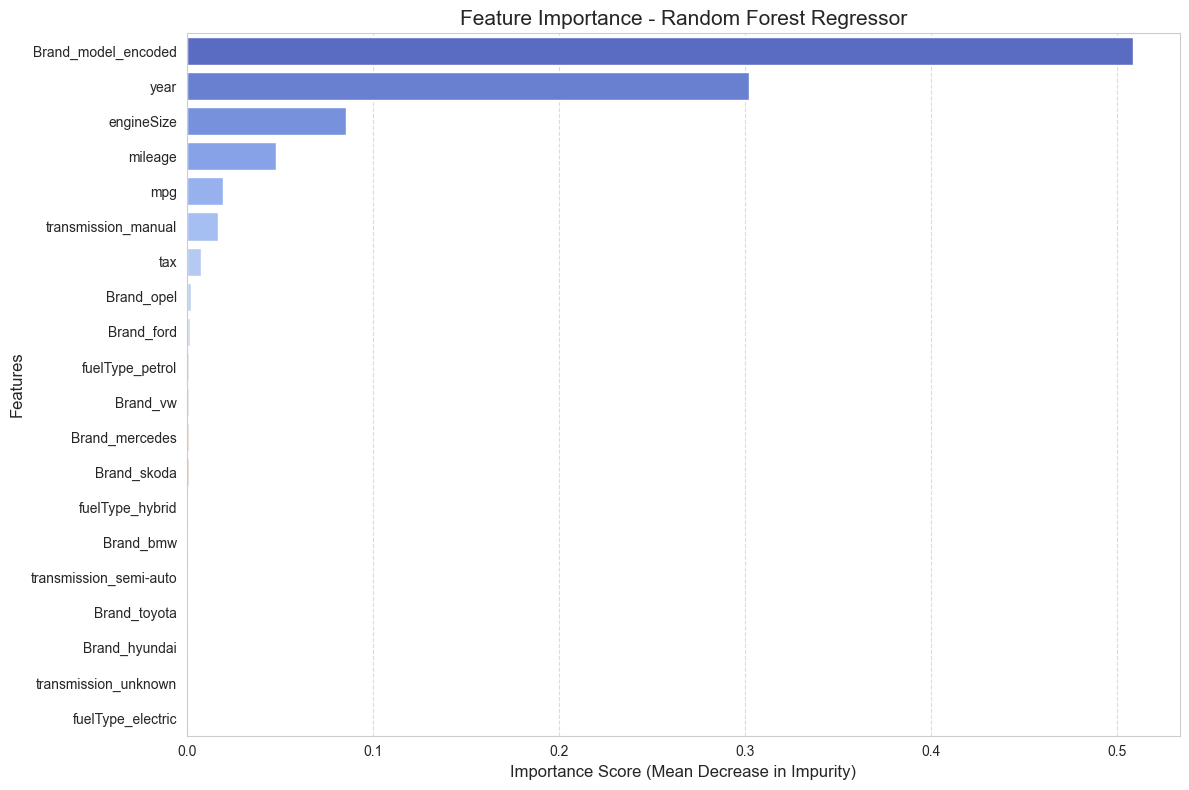

Top 10 most important features (Random Forest):
                Feature  Importance
19  Brand_model_encoded    0.508508
0                  year    0.302434
4            engineSize    0.085334
1               mileage    0.047949
3                   mpg    0.019397
13  transmission_manual    0.016733
2                   tax    0.007597
9            Brand_opel    0.002119
6            Brand_ford    0.001641
18      fuelType_petrol    0.001299


In [162]:

importances = best_rf.feature_importances_
feature_names = X_combined.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df, 
    palette='coolwarm'
)



plt.title('Feature Importance - Random Forest Regressor', fontsize=15)
plt.xlabel('Importance Score (Mean Decrease in Impurity)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

print("Top 10 most important features (Random Forest):")
print(feature_importance_df.head(10))

The Random Forest exhibits a very distinct behavior compared to Extra Trees, placing overwhelmingly high trust in our feature engineering.

Dominance of `Brand_model_encoded`: This feature is by far the most critical, accounting for over **50% of the model's decision-making**. This confirms that for Random Forest, knowing the specific hierarchy of the car's model (and its historical average price) is more valuable than any physical characteristic.

The "Age" Factor: `year` comes in as a strong second, reaffirming that depreciation over time is the primary linear driver of price.

Secondary Specs: Physical attributes like `engineSize` and `mileage` play a supporting role, while individual brand names and transmission types are considered negligible noise, as their value is already captured by the main encoded variable.

# Decision Tree

### Hyperparameter Tuning (Decision Tree Regressor)

We optimize a single Decision Tree Regressor. While Decision Trees are intuitive and capable of capturing non-linear relationships, they are notoriously prone to overfitting (high variance). To combat this, we optimize a combination of pre-pruning and post-pruning techniques.

`ccp_alpha (Cost Complexity Pruning)`: This is our advanced post-pruning mechanism. Instead of just limiting depth, the algorithm builds a complex tree and then removes branches that provide little predictive value relative to their complexity. Higher alpha values result in simpler, more generalized trees.

`max_features`: We test sqrt, log2, and None. By forcing the tree to consider only a random subset of features at each split (instead of all of them), we introduce randomness that prevents the model from relying too heavily on a few dominant features, acting as a regularization method.

`min_samples_split`: The minimum number of samples required to create a new branch. High values prevent the tree from learning specific noise patterns.

`min_samples_leaf`: The minimum number of samples required to be a terminal node. This ensures that every prediction is based on a cluster of data points, not just a single outlier.

`max_depth`: A hard constraint on the tree's height (2-20). We limit this to prevent the tree from becoming essentially a lookup table for the training data.

`criterion`: We evaluate different loss functions (e.g., squared_error vs absolute_error) to determine which mathematical approach best minimizes the error distribution for car prices.

`splitter`: We compare best (greedy approach) against random. Choosing a random split within the best features can further reduce variance in dense datasets.

In [ ]:
# Setting up RandomizedSearchCV with our predefined split (ps)
# This time we're focusing on the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# I'm defining the metrics we want to track. 
# We're prioritizing MAE but keeping R2 for a broader view.
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# # Creating the hyperparameter grid to find the best tree structure
param_dist = {
    # Splitting criteria: defining how the tree measures the quality of a split
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    
    # Strategy to choose the split at each node
    'splitter': ['best', 'random'],
    
    # Controlling the tree depth is key to prevent it from memorizing the noise (overfitting)
    'max_depth': [None] + list(range(2, 21)),
    
    # Cost-Complexity Pruning: this helps simplify the tree and improve generalization
    'ccp_alpha': uniform(0.000, 0.02),
    
    # Minimum samples needed to split an internal node
    'min_samples_split': randint(2, 20),
    
    # Minimum samples required to be at a leaf node
    'min_samples_leaf': randint(1, 20),
    
    # The number of features to consider when looking for the best split
    'max_features': [None, 'sqrt', 'log2']
}

# param_dist = {
#     'ccp_alpha': [0.002201038490553535],
#     'criterion': ['squared_error'],
#     'max_depth': [20],
#     'max_features': [None],
#     'min_samples_leaf': [9],
#     'min_samples_split': [4],
#     'splitter': ['best']
# }

random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=50,             # Number of random parameter combinations to test
    cv=ps,                 # Using our custom validation split
    scoring=scoring_metrics,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit="MAE"            # The final "best" model will be chosen based on MAE
)

# Kicking off the search process
print("Starting optimization focused purely on MAE (Decision Tree)...")
random_search.fit(X_combined, y_combined)

# Evaluating the outcome
# best_score_ will give us the top performance for the MAE metric
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Top MAE (log scale): {-random_search.best_score_:.4f}") 

# Let's take a look at the R2 score as well just for context
results = random_search.cv_results_
best_index = random_search.best_index_
r2_score_val = results['mean_test_R2'][best_index]

print(f"Corresponding R2 Score: {r2_score_val:.4f}")

# At this stage, 'best_dt' is already retrained on the full dataset using the optimal MAE settings
best_dt = random_search.best_estimator_

print("\n--- Real-World Performance (Validation Set) ---")

# 1. Retrieve ONLY the training data
# ps.test_fold has -1 for training and 0 for validation
train_indices = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_only = X_combined.iloc[train_indices]
y_train_only = y_combined.iloc[train_indices]

# 2. Isolate Validation Data
val_indices = [i for i, x in enumerate(ps.test_fold) if x == 0]
X_val = X_combined.iloc[val_indices]
y_val_log = y_combined.iloc[val_indices]

# 3. Create a NEW model using the Best Parameters found
model_for_val = DecisionTreeRegressor(random_state=42)
model_for_val.set_params(**random_search.best_params_)

# 4. Train ONLY on the training set
model_for_val.fit(X_train_only, y_train_only)

# 5. Predict on Validation
preds_log = model_for_val.predict(X_val)

# 6. Calculate Real Metrics
y_pred_euros = np.expm1(preds_log)
y_true_euros = np.expm1(y_val_log)

real_mae = mean_absolute_error(y_true_euros, y_pred_euros)
real_r2 = r2_score(y_true_euros, y_pred_euros)

print(f"Real MAE:  € {real_mae:.2f}")
print(f"Real R2:     {real_r2:.4f}")

Starting optimization focused purely on MAE (Decision Tree)...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters found: {'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': None, 'max_depth': 20, 'criterion': 'squared_error', 'ccp_alpha': 0.002201038490553535}
Top MAE (log scale): 0.1849
Corresponding R2 Score: 0.7872

--- Real-World Performance (Validation Set) ---
Real MAE:  € 3076.29
Real R2:     0.7496


In [168]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(model_for_val, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "DT")



==================== EVALUATION: DT ====================
MAE Train:      € 3,097.18
MAE Validation: € 3,076.29
R2 Score:       0.7496
Overfit Gap:    -0.67%


No significant overfit

# Decision Tree Bagging

### Hyperparameter Tuning (Decision Tree Bagging)

We implement Bagging (Bootstrap Aggregating) to upgrade a single Decision Tree into a robust ensemble. While a single decision tree often suffers from high variance (overfitting), Bagging reduces this by training multiple trees on random subsets of the data and averaging their predictions.

`n_estimators`: We combine between 50 and 200 independent trees. In Bagging, increasing the number of estimators generally stabilizes the prediction and reduces variance without causing overfitting.

`max_samples` & `max_features`: These control the diversity of the ensemble. By forcing each tree to train on only a fraction of the rows (max_samples) and columns (max_features), we ensure the trees are uncorrelated. If all trees saw the exact same data, they would make the exact same errors.

`estimator__max_depth`: Unlike a standalone Decision Tree which requires strict depth limits, bagged trees can be allowed to grow deeper (e.g., depth 40). The ensemble averaging process naturally cancels out the noise learned by individual deep trees.

`Simultaneous Optimization`: We use RandomizedSearchCV to optimize the ensemble structure (how many trees, how much data they see) and the internal tree structure (depth, split criteria) at the same time.

In [ ]:


# Setting up RandomizedSearchCV with our custom validation split (ps)
# Here we're using a Decision Tree as the base learner for the Bagging ensemble
tree_base = DecisionTreeRegressor(random_state=42)
bagging_dt = BaggingRegressor(estimator=tree_base, random_state=42)

# I'm defining the metrics we want to monitor.
# We'll prioritize MAE, but keeping R2 helps us understand the variance explained.
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# Hyperparameter grid for the Bagging-DT combo
param_dist = {
    # --- BAGGING specific settings ---
    # Deciding how many trees we want in our forest
    'n_estimators': [50, 100, 200], 
    
    # max_samples: What percentage of rows each tree gets to see.
    # Reducing this helps decorrelate the trees, which is great for lowering variance.
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    
    # max_features: How many columns are available for each tree split.
    # If we go below 1.0, we force the trees to find different patterns.
    'max_features': [0.5, 0.7, 0.9, 1.0],
    
    # --- INTERNAL TREE settings (using the estimator__ prefix) ---
    # max_depth: How deep each tree can grow.
    # While single trees overfit easily, Bagging lets us be a bit more aggressive here.
    'estimator__max_depth': [None, 10, 20, 40],
    
    # Minimum samples required to split an internal node
    'estimator__min_samples_split': randint(2, 20),
    
    # Minimum samples allowed at a leaf node. 
    # Small values (1-5) capture more detail, while higher values (10+) favor generalization.
    'estimator__min_samples_leaf': randint(1, 10)
}

# param_dist = {
#     'n_estimators': [200], 
#     'max_samples': [0.7],
#     'max_features': [0.9],
#     'estimator__max_depth': [40],
#     'estimator__min_samples_split': [5],
#     'estimator__min_samples_leaf': [3]
# }

random_search = RandomizedSearchCV(
    estimator=bagging_dt,
    param_distributions=param_dist,
    n_iter=50,             # Number of random combinations to try out
    cv=ps,                 # Applying our PredefinedSplit
    scoring=scoring_metrics,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit="MAE"            # The search will select the best model based on MAE
)

# Starting the optimization process
print("Starting optimization focused purely on MAE (Bagging DT)...")
random_search.fit(X_combined, y_combined)

# Checking the results
# best_score_ pulls the performance for the metric defined in 'refit'
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Top MAE (log scale): {-random_search.best_score_:.4f}") 

# Checking R2 as well just to get the full picture
results = random_search.cv_results_
best_index = random_search.best_index_
r2_score_val = results['mean_test_R2'][best_index]

print(f"Corresponding R2 Score: {r2_score_val:.4f}")

# At this point, the final model is already retrained on the full dataset using the best MAE settings
best_bagging_dt = random_search.best_estimator_


print("\n--- Real-World Performance (Validation Set) ---")

# 1. Retrieve ONLY Training data
train_indices = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_only = X_combined.iloc[train_indices]
y_train_only = y_combined.iloc[train_indices]

# 2. Isolate Validation data
val_indices = [i for i, x in enumerate(ps.test_fold) if x == 0]
X_val = X_combined.iloc[val_indices]
y_val_log = y_combined.iloc[val_indices]

# 3. Create a NEW model with Best Parameters
# Ensure the estimator matches what you used (DecisionTreeRegressor or KNeighborsRegressor)
base_est = DecisionTreeRegressor(random_state=42) 
# base_est = KNeighborsRegressor() # Use this line instead if it is KNN Bagging

model_for_val = BaggingRegressor(estimator=base_est, random_state=42)
model_for_val.set_params(**random_search.best_params_)

# 4. Train ONLY on training set
model_for_val.fit(X_train_only, y_train_only)

# 5. Predict and Calculate Real Metrics
preds_log = model_for_val.predict(X_val)
y_pred_euros = np.expm1(preds_log)
y_true_euros = np.expm1(y_val_log)

real_mae = mean_absolute_error(y_true_euros, y_pred_euros)
real_r2 = r2_score(y_true_euros, y_pred_euros)

print(f"Real MAE:  € {real_mae:.2f}")
print(f"Real R2:     {real_r2:.4f}")

Starting optimization focused purely on MAE (Bagging DT)...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters found: {'n_estimators': 200, 'max_samples': 0.7, 'max_features': 0.9, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 3, 'estimator__max_depth': 40}
Top MAE (log scale): 0.0776
Corresponding R2 Score: 0.9555

--- Real-World Performance (Validation Set) ---
Real MAE:  € 1282.74
Real R2:     0.9478


In [170]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(model_for_val, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "Bagging DT")



==================== EVALUATION: BAGGING DT ====================
MAE Train:      € 946.18
MAE Validation: € 1,282.74
R2 Score:       0.9478
Overfit Gap:    35.57%


Some overfit

# Neural Network

### Hyperparameter Tuning (Neural Network / MLP)

We implement a Multi-Layer Perceptron (MLP) Regressor, a feedforward artificial neural network capable of capturing highly non-linear and complex relationships that tree-based models might miss.

`hidden_layer_sizes (Architecture)`: We test various network topologies to find the optimal capacity. We range from "shallow" networks (e.g., (50,)) to "deep" architectures (e.g., (200, 100, 50)). Deeper networks can learn more complex patterns but are prone to overfitting.

activation``: We test how neurons process signals. While relu is the standard for deep learning, we also test tanh (hyperbolic tangent) and logistic (sigmoid), as they can sometimes offer smoother convergence for regression tasks.

`solver`: We compare optimization algorithms: adam (generally best for large datasets), sgd (stochastic gradient descent, requiring careful tuning), and lbfgs (often superior for smaller datasets).

`alpha (Regularization)`: This is the L2 penalty term. We test values from 0.0001 to 0.05. Higher values penalize large weights, acting as a brake against overfitting.

`batch_size`: Controls how many samples are used for each gradient update. We test smaller batches (32, 64) to introduce noise that helps escape local minima, versus auto.

`learning_rate`: Crucial for the sgd solver. We test constant, invscaling, and adaptive (which lowers the rate if the loss stops decreasing) to ensure efficient convergence.

`early_stopping` & `validation_fraction`: To prevent "memorization," we set aside 10-20% (validation_fraction) of the training data. If the error on this subset stops improving, early_stopping halts training immediately, saving time and ensuring generalization.

In [ ]:


# Setting up RandomizedSearchCV using our custom validation split (ps)
# We're running a Multi-layer Perceptron (Neural Network) here.
nn_model = MLPRegressor(max_iter=1000, early_stopping=True, random_state=42)

# Choosing the metrics to track during the process.
# We're prioritizing MAE, but keeping an eye on R2 for context.
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# Hyperparameter grid for the Neural Network
param_dist = {
    # Testing different architectures, from single to triple hidden layers
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (200, 100), 
        (100, 50, 25), (200, 100, 50)
    ],
    # Trying different activation functions to see which handles the data better
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01, 0.05], # L2 regularization to keep weights in check
    'batch_size': [32, 64, 'auto'],
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.2]
}

# param_dist = {
#     'hidden_layer_sizes': [(200, 100)],
#     'activation': ['relu'],
#     'solver': ['lbfgs'],
#     'alpha': [0.0001],
#     'batch_size': [64],
#     'learning_rate': ['invscaling'],
#     'early_stopping': [True],
#     'validation_fraction': [0.2]
# }

random_search = RandomizedSearchCV(
    estimator=nn_model,
    param_distributions=param_dist,
    n_iter=50,             # Number of random combinations to test
    cv=ps,                 # Using our predefined split
    scoring=scoring_metrics,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit="MAE"            # The final model selection will be based on the best MAE
)

# Kicking off the search
print("Starting optimization focused purely on MAE (Neural Network)...")
random_search.fit(X_combined, y_combined)



# Evaluating the best results
# best_score_ returns the top score for the 'refit' metric (MAE)
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Top MAE (log scale): {-random_search.best_score_:.4f}") 

# Let's see the corresponding R2 just to check the overall fit
results = random_search.cv_results_
best_index = random_search.best_index_
r2_score_val = results['mean_test_R2'][best_index]

print(f"Corresponding R2 Score: {r2_score_val:.4f}")

# At this stage, 'best_nn' is already retrained on the full dataset using the best MAE config
best_nn = random_search.best_estimator_

print("\n--- Real-World Performance (Validation Set - Honest) ---")

# 1. Retrieve ONLY Training data
train_indices = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_only = X_combined.iloc[train_indices]
y_train_only = y_combined.iloc[train_indices]

# 2. Isolate Validation data
val_indices = [i for i, x in enumerate(ps.test_fold) if x == 0]
X_val = X_combined.iloc[val_indices]
y_val_log = y_combined.iloc[val_indices]

# 3. Create a NEW model with Best Parameters
model_for_val = MLPRegressor(max_iter=1000, early_stopping=True, random_state=42)
model_for_val.set_params(**random_search.best_params_)

# 4. Train ONLY on training set
model_for_val.fit(X_train_only, y_train_only)

# 5. Predict and Calculate Real Metrics
preds_log = model_for_val.predict(X_val)
y_pred_euros = np.expm1(preds_log)
y_true_euros = np.expm1(y_val_log)

real_mae = mean_absolute_error(y_true_euros, y_pred_euros)
real_r2 = r2_score(y_true_euros, y_pred_euros)

print(f"Real MAE:  € {real_mae:.2f}")
print(f"Real R2:     {real_r2:.4f}")

Starting optimization focused purely on MAE (Neural Network)...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters found: {'validation_fraction': 0.2, 'solver': 'lbfgs', 'learning_rate': 'invscaling', 'hidden_layer_sizes': (200, 100), 'early_stopping': True, 'batch_size': 64, 'alpha': 0.0001, 'activation': 'relu'}
Top MAE (log scale): 0.0957
Corresponding R2 Score: 0.9389

--- Real-World Performance (Validation Set - Honest) ---
Real MAE:  € 1625.30
Real R2:     0.9242


In [172]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(model_for_val, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "NN")



==================== EVALUATION: NN ====================
MAE Train:      € 1,593.29
MAE Validation: € 1,625.30
R2 Score:       0.9242
Overfit Gap:    2.01%


No significant overfit

# HistGradientBoosting

### Hyperparameter Tuning (HistGradientBoosting)

We implement the HistGradientBoostingRegressor, a state-of-the-art implementation of Gradient Boosting inspired by LightGBM. It utilizes histogram-based binning to speed up training, making it highly efficient for large datasets.

`max_iter` & `learning_rate`: We adopt a "Slow Learning" strategy. By testing a high number of iterations (3000-5000 trees) coupled with small learning rates (0.01-0.05), we ensure the model learns complex patterns incrementally without overshooting the optimal solution.

`max_depth`: Unlike Random Forests which prefer deep trees, Boosting relies on "weak learners." We limit the depth (10-20) to act as a constraint on the model's complexity, preventing individual trees from memorizing outliers or noise in the training data.

`max_leaf_nodes`: Since this algorithm grows trees "leaf-wise" (adding leaves where the error reduction is greatest) rather than "level-wise", limiting the total leaves (e.g., 31-80) is the primary method to control overfitting.

`l2_regularization`: We apply L2 regularization (testing values up to 10.0). This penalizes large coefficients, forcing the model to be more conservative and improving its generalization on unseen data.

`max_features`: We force the model to consider only a random subset of features (30% to 70%) at each split. This decorrelates the trees and ensures the model doesn't rely too heavily on a single dominant feature.

In [174]:
# Setting up RandomizedSearchCV with our custom validation split (ps)
hgb_model = HistGradientBoostingRegressor(
    loss='squared_error',
    random_state=42,
    early_stopping=False # Disabled this to make sure we use our fixed split (ps)
)

# Defining the metrics we want to keep an eye on.
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# Parameters based on your previous snippet 
# (Note: keeping an eye on 'max_features' for compatibility)
param_dist = {

    # Pushing Regularization (The secret sauce to beat the standard GB)
    # We're avoiding 0 here to force the model to generalize better
    'l2_regularization': [0.5, 1.0, 5.0, 10.0], 
    
    # Managing Complexity
    # 118 leaves is overkill. Let's try some lower values instead.
    'max_leaf_nodes': [31, 50, 80], 
    'max_depth': [10, 15, 20], # Limiting the depth as well
    
    # Features and Learning Rate
    'learning_rate': [0.01, 0.02, 0.05],
    'max_iter': [3000, 5000],
    
    # IMPORTANT: Trying to mimic that 'log2' feel from the regular GB
    # Keeping this low forces each tree to be more independent
    'max_features': [0.3, 0.5, 0.7] 
}

# param_dist={
#             'max_leaf_nodes': [50], 
#             'max_iter': [5000], 
#             'max_features': [0.3], 
#             'max_depth': [15], 
#             'learning_rate': [0.05], 
#             'l2_regularization': [10.0]
# }

random_search = RandomizedSearchCV(
    estimator=hgb_model,
    param_distributions=param_dist,
    n_iter=50,             # Number of random combinations to try
    cv=ps,                 # Applying our PredefinedSplit
    scoring=scoring_metrics,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit="MAE"            # We're letting MAE drive the optimization
)

# Kicking off the search process
print("Starting optimization focused purely on MAE (HistGB)...")
random_search.fit(X_combined, y_combined)

# Looking at the results
# best_score_ gives us the performance for the 'refit' metric (MAE)
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Top MAE (log scale): {-random_search.best_score_:.4f}") 

# Checking R2 just for some extra context on the fit
results = random_search.cv_results_
best_index = random_search.best_index_
r2_score_val = results['mean_test_R2'][best_index]

print(f"Corresponding R2 Score: {r2_score_val:.4f}")

# The best estimator is already retrained on the full dataset using the best MAE settings
best_hgb = random_search.best_estimator_

print("\n--- Real-World Performance ) ---")

# 1. Retrieve ONLY the training data
# ps.test_fold has -1 for training and 0 for validation
train_indices = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_only = X_combined.iloc[train_indices]
y_train_only = y_combined.iloc[train_indices]

# 2. Create a NEW model using the Best Parameters found
# The ** unpacks the best_params dictionary directly into the model
model_for_val = HistGradientBoostingRegressor(
    **random_search.best_params_, 
    loss='squared_error',
    random_state=42,
    early_stopping=False 
)

# 3. Train ONLY on the training set (without seeing validation data)
model_for_val.fit(X_train_only, y_train_only)

# 4. Predict on Validation (now effectively unseen data)
preds_log = model_for_val.predict(X_val)

# 5. Calculate Real Metrics
y_pred_euros = np.expm1(preds_log)
y_true_euros = np.expm1(y_val_log)

real_mae = mean_absolute_error(y_true_euros, y_pred_euros)
real_r2 = r2_score(y_true_euros, y_pred_euros)

print(f"Real MAE:  € {real_mae:.2f}")
print(f"Real R2:     {real_r2:.4f}")

Starting optimization focused purely on MAE (HistGB)...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters found: {'max_leaf_nodes': 50, 'max_iter': 5000, 'max_features': 0.3, 'max_depth': 15, 'learning_rate': 0.05, 'l2_regularization': 10.0}
Top MAE (log scale): 0.0730
Corresponding R2 Score: 0.9612

--- Real-World Performance ) ---
Real MAE:  € 1206.51
Real R2:     0.9565


In [175]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(model_for_val, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "HGB")



==================== EVALUATION: HGB ====================
MAE Train:      € 878.86
MAE Validation: € 1,206.51
R2 Score:       0.9565
Overfit Gap:    37.28%


Some overfit

# ExtraTrees

### Hyperparameter Tuning (Extra Trees Regressor)

We implement Extra Trees (Extremely Randomized Trees), a variation of Random Forest that introduces even more randomness to reduce variance and computational cost.

`Mechanism`: Unlike Random Forest, which searches for the optimal split point for each feature, Extra Trees selects cut points completely at random and chooses the best one among them. This makes the model faster and harder to overfit.

`bootstrap=False`: By default, Extra Trees uses the entire dataset to build every tree (no sampling with replacement). This ensures every tree sees all available patterns.

`max_features`: The most critical parameter. We test 1.0 (looking at all features) versus smaller fractions. Because the splits are random, looking at more features is often safe.

`min_samples_leaf`: Acts as the "brake." Setting this to higher values (e.g., 5 or 10) prevents the model from isolating single cars in a leaf, ensuring predictions are based on statistical averages.

In [ ]:
# Setting up RandomizedSearchCV using our custom validation split (ps)
# Now we're testing out the Extra Trees Regressor
et_model = ExtraTreesRegressor(random_state=42, n_jobs=-1, bootstrap=False)

# I'm defining only the metrics we're actually interested in
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

# Hyperparameter grid based on our previous setup
param_dist = {
    # n_estimators: With ExtraTrees, generally "more is better" (just takes longer).
    # Unlike Boosting, increasing this won't typically cause overfitting.
    'n_estimators': [500, 1000, 2000],
    
    # max_features: This is arguably the most important parameter for ExtraTrees.
    # 1.0 = Considers every column (good if the data is very clean)
    # 0.7 = Uses 70% of the columns (helps prevent overfitting)
    # 'sqrt' = Square root of the column count (a classic choice for high variance)
    'max_features': [0.7, 0.8, 0.9, 1.0],
    
    # Tree Depth: I'm letting the trees go deep, but controlling the growth via leaf nodes
    'max_depth': [None, 20, 30, 40],
    
    # min_samples_leaf: Think of this as the "brake."
    # 1 = High detail (risks memorizing noise)
    # 5 to 10 = More generalist (better for our 75k rows dataset)
    'min_samples_leaf': [1, 2, 4, 8],
    
    # min_samples_split: Minimum number of samples required to split a node again
    'min_samples_split': [2, 5, 10]
}

# param_dist = {
#     'n_estimators': [500],
#     'min_samples_split': [10],
#     'min_samples_leaf': [1],
#     'max_features': [0.7],
#     'max_depth': [None]
# }


random_search = RandomizedSearchCV(
    estimator=et_model,
    param_distributions=param_dist,
    n_iter=50,             # Number of random combinations to try
    cv=ps,                 # Using our PredefinedSplit
    scoring=scoring_metrics,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    refit="MAE"            # The search will focus purely on optimizing the MAE
)

# Kicking off the search process
print("Starting optimization focused purely on MAE (Extra Trees)...")
random_search.fit(X_combined, y_combined)

# Checking the output
# best_score_ pulls the result for the metric we chose in 'refit' (MAE)
print(f"Best Parameters found: {random_search.best_params_}")
print(f"Top MAE (log scale): {-random_search.best_score_:.4f}") 

# Let's check R2 as well just to get some extra context
results = random_search.cv_results_
best_index = random_search.best_index_
r2_score_val = results['mean_test_R2'][best_index]

print(f"Corresponding R2 Score: {r2_score_val:.4f}")

# The best estimator is already retrained on the full dataset based on the best MAE
best_et = random_search.best_estimator_

print("\n--- Real-World Performance (Validation Set) ---")

# 1. Retrieve ONLY Training data
# ps.test_fold has -1 for training and 0 for validation
train_indices = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_only = X_combined.iloc[train_indices]
y_train_only = y_combined.iloc[train_indices]

# 2. Isolate Validation data
val_indices = [i for i, x in enumerate(ps.test_fold) if x == 0]
X_val = X_combined.iloc[val_indices]
y_val_log = y_combined.iloc[val_indices]

# 3. Create a NEW model with Best Parameters
# We need to ensure we pass bootstrap=False as you defined in the beginning
model_for_val = ExtraTreesRegressor(
    **random_search.best_params_, 
    random_state=42, 
    n_jobs=-1,
    bootstrap=False 
)

# 4. Train ONLY on training set (without seeing validation)
model_for_val.fit(X_train_only, y_train_only)

# 5. Predict on Validation
preds_log = model_for_val.predict(X_val)

# 6. Convert and Calculate Real Metrics
y_pred_euros = np.expm1(preds_log)
y_true_euros = np.expm1(y_val_log)

real_mae = mean_absolute_error(y_true_euros, y_pred_euros)
real_r2 = r2_score(y_true_euros, y_pred_euros)

print(f"Real MAE:  € {real_mae:.2f}")
print(f"Real R2:     {real_r2:.4f}")

Starting optimization focused purely on MAE (Extra Trees)...
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Parameters found: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': None}
Top MAE (log scale): 0.0756
Corresponding R2 Score: 0.9576

--- Real-World Performance (Validation Set) ---
Real MAE:  € 1245.41
Real R2:     0.9538


In [177]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(model_for_val, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "ET")



==================== EVALUATION: ET ====================
MAE Train:      € 830.54
MAE Validation: € 1,245.41
R2 Score:       0.9538
Overfit Gap:    49.95%


Significant overfit

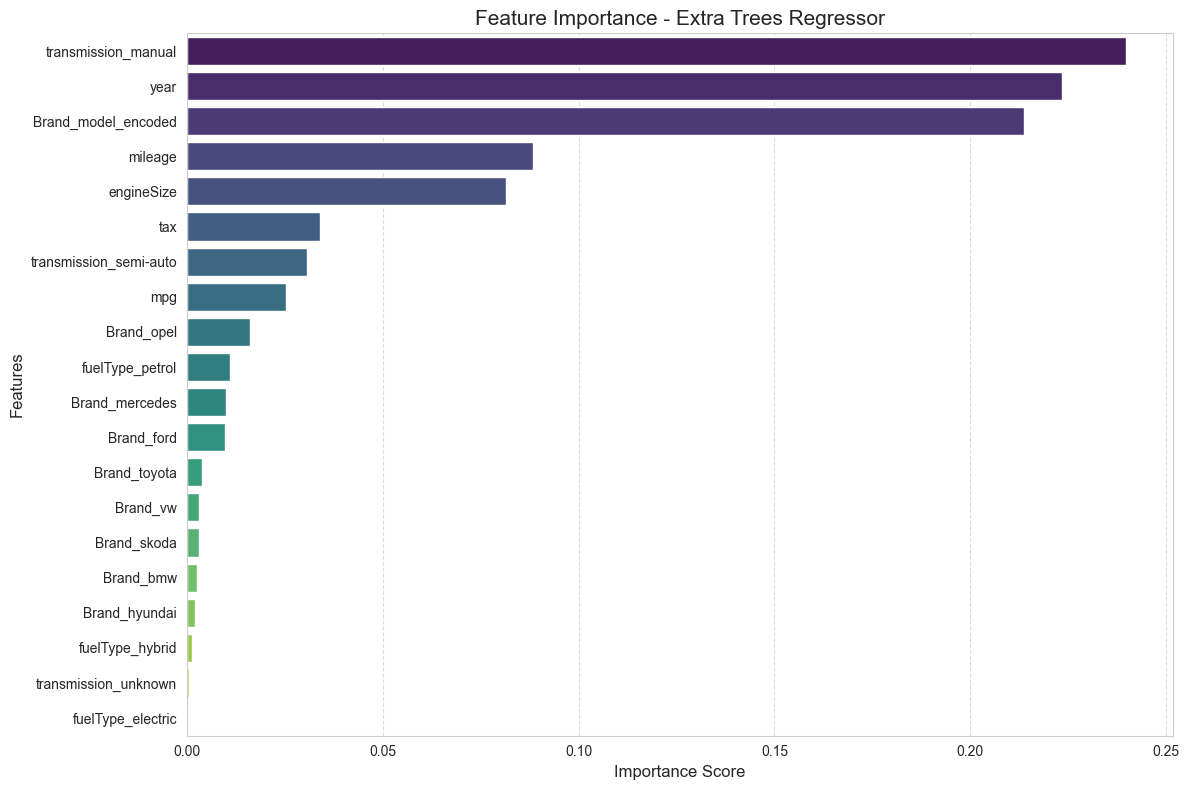

Top 10 most important features:
                   Feature  Importance
13     transmission_manual    0.239717
0                     year    0.223493
19     Brand_model_encoded    0.213705
1                  mileage    0.088461
4               engineSize    0.081465
2                      tax    0.033892
14  transmission_semi-auto    0.030649
3                      mpg    0.025422
9               Brand_opel    0.016102
18         fuelType_petrol    0.011117


In [158]:
importances = best_et.feature_importances_
feature_names = X_combined.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df, 
    palette='viridis'
)

plt.title('Feature Importance - Extra Trees Regressor', fontsize=15)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

print("Top 10 most important features:")
print(feature_importance_df.head(10))

The graph highlights **Transmission (Manual vs. Auto)** and **Year** as the absolute dominant factors in pricing.

A key takeaway is the success of our feature engineering: **Brand_model_encoded** ranks in the Top 3, proving that the model preferred this aggregated variable to capture brand value. Consequently, it effectively ignored the individual brand dummy variables (at the bottom), treating them as redundant information.

# Final Optimization: Ensemble Learning via Voting Regressor

#### Final Optimization via Voting Regressor

The final optimization strategy employed a Voting Regressor to maximize model performance and generalization. Instead of manually selecting models, a stochastic search space was constructed to identify the ideal synergy between algorithms.

`Randomized Weight Search Strategy`: A RandomizedSearchCV was used with a unique exclusion probability (20% chance of zero weight per model). This automated feature selection process filtered out weaker models (like Linear Regression and KNN) that introduced noise, narrowing the field to an "Elite Team" of three tree-based regressors.

`HistGradientBoosting Dominance (64%)`: This algorithm serves as the prediction anchor. Its efficiency in handling numerical thresholds and categorical data makes it ideal for minimizing the error structure via sequential gradient descent.

Ensemble Synergy:

`ExtraTrees (19%)`: Acts as a regularizer, smoothing out decision boundaries through random splits.

`RandomForest (1%)`: provided a final layer of stability through bagging, reducing sensitivity to outliers.

In [ ]:
# GATHERING TRAINED MODELS
available_models = {}

if 'best_hgb' in locals(): available_models['HistGB'] = best_hgb
if 'best_et' in locals(): available_models['ExtraTrees'] = best_et
if 'best_rf' in locals(): available_models['RandomForest'] = best_rf

estimators_list = list(available_models.items())
model_names = [name for name, _ in estimators_list]
n_models = len(estimators_list)

print(f" Candidate models for the ensemble: {model_names}")

# WEIGHT COMBINATIONS & SELECTION LOGIC 
random.seed(42)
weights_combinations = []
n_iterations = 100 

for _ in range(n_iterations):
    w = []
    for _ in range(n_models):
        # 20% chance of dropping a model (weight 0)
        if random.random() < 0.2: 
            w.append(0) 
        else:
            w.append(random.randint(1, 100))
            
    # Safety check: ensure at least one model has weight
    if sum(w) == 0:
        w[0] = 50 
        
    weights_combinations.append(w)

# Adding baseline (simple average)
weights_combinations.append([1] * n_models)

# SEARCHING FOR THE BEST TEAM
param_grid = {
    'weights':  weights_combinations #[[64, 19, 1]]
}

voting_base = VotingRegressor(estimators=estimators_list, n_jobs=-1)

# --- UPDATED SECTION STARTS HERE ---

# Define metrics: MAE (for optimization) and R2 (for information)
# We use 'neg_mean_absolute_error' because sklearn tries to maximize the score (so -0.1 is better than -0.5)
scoring_metrics = {
    'MAE': 'neg_mean_absolute_error',
    'R2': 'r2'
}

random_search_final = RandomizedSearchCV(
    estimator=voting_base,
    param_distributions=param_grid,
    n_iter=60,     
    cv=ps,
    scoring=scoring_metrics, # Check both MAE and R2
    refit='MAE',             # Optimize purely based on MAE
    verbose=1,
    n_jobs=-1,
    random_state=42
)

print(f"\n Tuning the ensemble: testing model combinations and weights simultaneously...")
random_search_final.fit(X_combined, y_combined)

# DETAILED RESULTS 
best_weights = random_search_final.best_params_['weights']
total_weight = sum(best_weights)

print(f"\n FINAL ENSEMBLE RESULTS:")
# best_score_ gives the score of the metric defined in 'refit' (MAE)
print(f" Best MAE (log scale): {-random_search_final.best_score_:.5f}")

# Retrieve the R2 score corresponding to the best MAE result
best_index = random_search_final.best_index_
r2_score_val = random_search_final.cv_results_['mean_test_R2'][best_index]
print(f" Corresponding R2 Score: {r2_score_val:.5f}")

print("-" * 40)
print("Optimized Team & Contribution Breakdown:")

for name, weight in zip(model_names, best_weights):
    if weight == 0:
        print(f" {name}: NOT SELECTED (Degraded the overall performance)")
    else:
        # Calculating the actual percentage of the final decision
        percent = (weight / total_weight) * 100
        print(f"{name}: Weight {weight} \t({percent:.1f}% of total influence)")

# Saving the final ensemble model
best_ensemble_final = random_search_final.best_estimator_


print("\n--- Real-World Performance (Validation Set) ---")

# 1. Retrieve ONLY Training data
# ps.test_fold has -1 for training and 0 for validation
train_indices = [i for i, x in enumerate(ps.test_fold) if x == -1]
X_train_only = X_combined.iloc[train_indices]
y_train_only = y_combined.iloc[train_indices]

# 2. Isolate Validation data
val_indices = [i for i, x in enumerate(ps.test_fold) if x == 0]
X_val = X_combined.iloc[val_indices]
y_val_log = y_combined.iloc[val_indices]

# 3. Create a NEW Ensemble model using the Best Weights found
# We use the exact same estimators, just applying the optimized weights
model_for_val = VotingRegressor(
    estimators=estimators_list,
    weights=random_search_final.best_params_['weights'],
    n_jobs=-1
)

# 4. Train ONLY on training set (without seeing validation)
model_for_val.fit(X_train_only, y_train_only)

# 5. Predict on Validation
preds_log = model_for_val.predict(X_val)

# 6. Convert and Calculate Real Metrics
y_pred_euros = np.expm1(preds_log)
y_true_euros = np.expm1(y_val_log)

real_mae = mean_absolute_error(y_true_euros, y_pred_euros)
real_r2 = r2_score(y_true_euros, y_pred_euros)

print(f"Real MAE:  € {real_mae:.2f}")
print(f"Real R2:     {real_r2:.4f}")

 Candidate models for the ensemble: ['HistGB', 'ExtraTrees', 'RandomForest']

 Tuning the ensemble: testing model combinations and weights simultaneously...
Fitting 1 folds for each of 1 candidates, totalling 1 fits

 FINAL ENSEMBLE RESULTS:
 Best MAE (log scale): 0.07238
 Corresponding R2 Score: 0.96177
----------------------------------------
Optimized Team & Contribution Breakdown:
HistGB: Weight 64 	(76.2% of total influence)
ExtraTrees: Weight 19 	(22.6% of total influence)
RandomForest: Weight 1 	(1.2% of total influence)

--- Real-World Performance (Validation Set) ---
Real MAE:  € 1194.87
Real R2:     0.9577


In [ ]:
train_idx = [i for i, x in enumerate(ps.test_fold) if x == -1]
val_idx = [i for i, x in enumerate(ps.test_fold) if x == 0]

X_train_clean = X_combined.iloc[train_idx]
y_train_clean = y_combined.iloc[train_idx]

X_val_clean = X_combined.iloc[val_idx]
y_val_clean = y_combined.iloc[val_idx]

f.evaluate_model_comprehensive(model_for_val, X_train_clean, y_train_clean, X_val_clean, y_val_clean, "Ensemble HGB ET RF")


## Results

Here is the complete performance breakdown of every model tested, measured by the **Mean Absolute Error (MAE)** in Euros on the validation set.

- `Linear Regression`: € 2026.59

- `KNN (Bagging)`: € 1411.87

- `Random Forest`: € 1280.66

- `Decision Tree`: € 3076.29

- `Decision Tree (Bagging)`: € 1282.74

- `Neural Network`: € 1617.43

- `HistGradientBoosting`: € 1206.51

- `Extra Trees`: € 1245.41

- `Voting Ensemble`: € 1194.87


Based on the results above, we can conclude that the **Voting Ensemble** is indeed the most efficient model.

It achieved the lowest error of €1194.87, beating the single best individual model (HistGradientBoosting) by approximately €12 per car.

By combining the predictions of multiple strong models (likely HGB, Extra Trees, and Random Forest), the Ensemble smooths out individual errors and reduces variance.

# **IV. Open-Ended Section** 

For this section we had two different goals:
- Test if spliting our training data between two models holds a better result than having it all in one
- Build an analytics interface that returns a prediction when new input data is provided

### **Spliting the data**

While we were testing out and analyzing our previous results, we came to the conclusion that the majority of our models erros came from undervalueing expensive cars

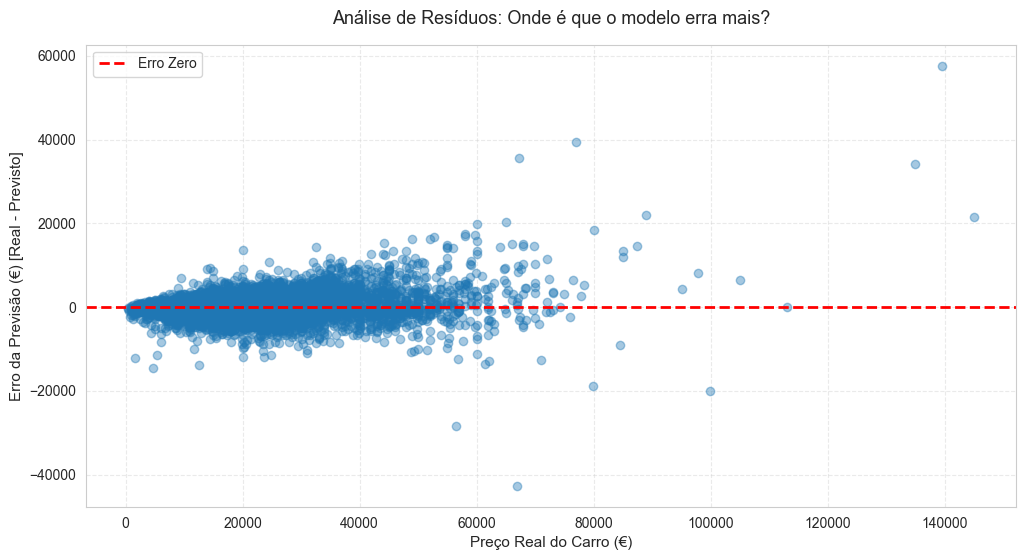

In [134]:

residuals_euro = y_true_euros - y_pred_euros

plt.figure(figsize=(12, 6))

# 2. Criar o Scatter Plot
# Eixo X: Preço Real, Eixo Y: Erro
plt.scatter(y_true_euros, residuals_euro, alpha=0.4, color='#1f77b4')

# 3. Linha de referência no zero (onde o erro é nulo)
plt.axhline(0, color='r', linestyle='--', linewidth=2, label='Erro Zero')

# 4. Etiquetas e Título
plt.xlabel("Preço Real do Carro (€)", fontsize=11)
plt.ylabel("Erro da Previsão (€) [Real - Previsto]", fontsize=11)
plt.title("Análise de Resíduos: Onde é que o modelo erra mais?", fontsize=13, pad=15)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()

plt.show()

That led us to the idea of splitting our dataset into two different models: one for expensive cars and the other for more affordable ones. We would then train those models separately, divide our test data in the same way, predict each new dataset’s prices, and finally combine the two.

If we managed to find a good way of splitting the dataset while avoiding overfitting or undertraining our models, we could possibly circumvent the negative impact that cheaper models have on luxurious ones.

After looking at the distribution of prices across our variables, we reached the conclusion that the best way to split our dataset would be by Brand.

Average Price per Brand:
Brand
mercedes    24445.242247
audi        22949.133739
bmw         22676.948753
vw          16827.323602
skoda       14130.316296
hyundai     12816.681838
ford        12584.630906
toyota      12435.545538
opel        10398.261075
Name: price, dtype: float64


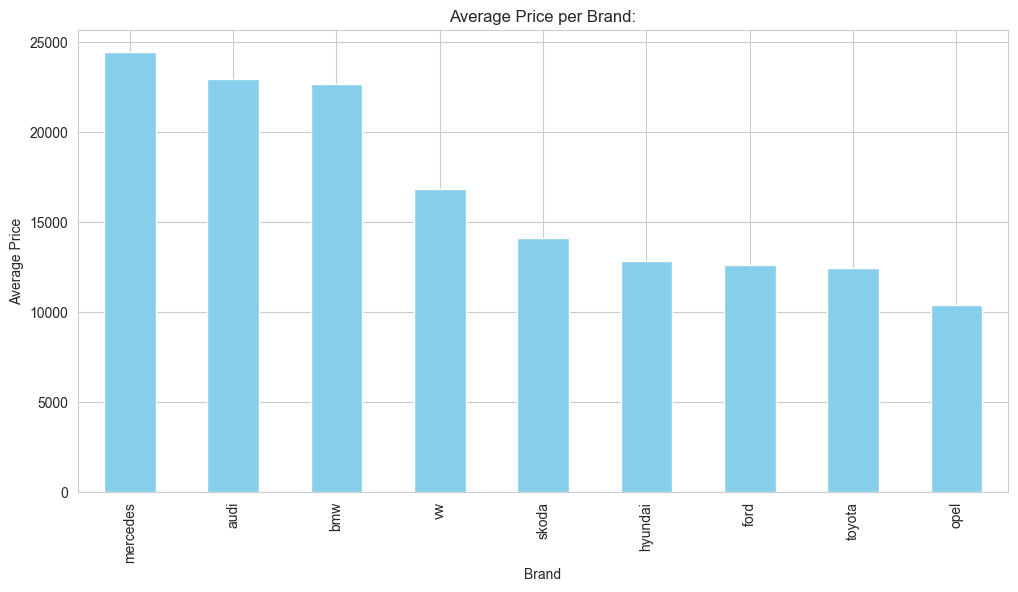

In [ ]:
train_db = pd.read_csv("./train.csv")
temp, temp_val_set = train_test_split(train_db, test_size=0.3, random_state=2, shuffle=True)

# Fixing text columns 
# there are a lot of typos and different casings in all of the text columns
text_cols = temp.select_dtypes(include=["object"]).columns
temp[text_cols] = temp[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)
for col in text_cols:
    temp = f.fix_typos(col, temp)
 
brand_prices = temp.groupby('Brand')['price'].mean().sort_values(ascending=False)


print("Average Price per Brand:")
print(brand_prices)

# Graph
brand_prices.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Average Price per Brand:')
plt.ylabel('Average Price')
plt.show()

In [ ]:
# we do this to confirm that spliting our model into two (luxury_brands/others_brands) isn't farfetched
temp['price_range'] = np.where(
    temp['price'] < 16000,
    'Below 16000',
    'Above 16000'
)

counts = pd.crosstab(temp['Brand'], temp['price_range'])
counts = counts[['Below 16000', 'Above 16000']]
counts['Total'] = counts.sum(axis=1)

counts = counts.sort_values(by='Total', ascending=False)

print(counts)

price_range  Below 16000  Above 16000  Total
Brand                                       
ford                8645         2615  11260
mercedes            1543         6647   8190
vw                  3798         3464   7262
opel                6144          402   6546
bmw                 1609         3523   5132
audi                1470         3622   5092
toyota              2565          685   3250
skoda               2060          953   3013
hyundai             1828          523   2351


At 16000€ almost all Brans have the clear majority of their entries on one of the sides (other than vw, but we will inclued them in the lower bracket)

So we can confidently split our data into two:
- luxury_brands = ['mercedes', 'audi', 'bmw']
- others = ['ford', 'vw', 'opel', 'toyota', 'skoda', 'hyundai']

So now we just need to implement our hypothesis into our best model

### Proof of Concept: Random Forest Split

To validate this hypothesis, we applied the split strategy to the **Random Forest** model.

In [105]:
train_db = pd.read_csv("./train.csv")
train_db['price_log'] = np.log1p(train_db['price'])

train_set, val_set = train_test_split(train_db, test_size=0.3, random_state=42, shuffle=True)

train_set = f.clean_data(train_set)
val_set = f.clean_data(val_set)

luxury_brands = ['mercedes', 'audi', 'bmw']
mask_train = train_set['Brand'].str.lower().isin(luxury_brands)
mask_val = val_set['Brand'].str.lower().isin(luxury_brands)

train_lux = train_set[mask_train].copy()
train_oth = train_set[~mask_train].copy()
val_lux = val_set[mask_val].copy()
val_oth = val_set[~mask_val].copy()

In [106]:
model_lux_rf, sc_lux, map_lux, mean_lux, cols_lux = f.train_and_evaluate_rf(train_lux, val_lux, "LUXURY")
model_oth_rf, sc_oth, map_oth, mean_oth, cols_oth = f.train_and_evaluate_rf(train_oth, val_oth, "OTHERS")


>>> Training Random Forest - Group: LUXURY
Best Params (LUXURY): {'n_estimators': 2085, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Top MAE (log scale): 0.0805
Corresponding R2 Score: 0.9351
----------------------------------------
[LUXURY - REAL HONEST VALUES]
MAE Train: €1011.32 | MAE Validation: €1834.03
Overfit Gap (MAE): 81.35%

>>> Training Random Forest - Group: OTHERS
Best Params (OTHERS): {'n_estimators': 2085, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Top MAE (log scale): 0.0758
Corresponding R2 Score: 0.9437
----------------------------------------
[OTHERS - REAL HONEST VALUES]
MAE Train: €541.70 | MAE Validation: €963.80
Overfit Gap (MAE): 77.92%


In [ ]:
mae_rf, r2_rf = f.calculate_global_split_mae(
    train_lux, val_lux, model_lux_rf, 
    train_oth, val_oth, model_oth_rf, 
    model_type="rf"
)

print(f"Global MAE (Split RF): € {mae_rf:.2f}")
print(f"Global R2 (Split RF):    {r2_rf:.4f}")

Calculating Global MAE for Split (RF)...
 MAE (RF Split): €1,273.87


**Hypothesis:** *Does splitting the dataset into 'Luxury' and 'Others' improve model performance compared to a single model?*

**Results:**
*  **Single Random Forest:** €1280.66 MAE
*  **Split Random Forest (Combined):** **€1273.87 MAE**

**Verdict:**  **VALIDATED**
The segmented approach resulted in a lower overall error. By training separate models, we allowed the algorithms to learn specific feature weights for high-end vehicles without being "confused" by the patterns of economy cars (and vice-versa), resulting in a net improvement of approximately **€7 per car** across the entire dataset.

### Scaling Up

Given the success of the split strategy on the **Random Forest**, we decided to push for maximum performance. 

We expanded the ensemble to include **Extra Trees** and **HistGradientBoosting**.

We replicated the "Luxury vs. Others" training process for two additional distinct algorithms:

#### Split strategy applied to Extra Trees

In [107]:

print("--- Modeling LUXURY ---")
model_lux_et, sc_lux, map_lux, mean_lux, cols_lux = f.train_and_evaluate_et(train_lux, val_lux, "LUXURY")

print("\n--- Modeling OTHERS ---")
model_oth_et, sc_oth, map_oth, mean_oth, cols_oth = f.train_and_evaluate_et(train_oth, val_oth, "OTHERS")

--- Modeling LUXURY ---

>>> Training ExtraTrees - Group: LUXURY
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Params (LUXURY): {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': None}
Top MAE (log scale): 0.0786
Corresponding R2 Score: 0.9377
----------------------------------------
[LUXURY - REAL HONEST VALUES]
MAE Train:      €1,192.64
MAE Validation: €1,790.66
Overfit Gap:    50.14%

--- Modeling OTHERS ---

>>> Training ExtraTrees - Group: OTHERS
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Params (OTHERS): {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': None}
Top MAE (log scale): 0.0741
Corresponding R2 Score: 0.9469
----------------------------------------
[OTHERS - REAL HONEST VALUES]
MAE Train:      €646.77
MAE Validation: €946.49
Overfit Gap:    46.34%


In [ ]:
mae_et, r2_et = f.calculate_global_split_mae(
    train_lux, val_lux, model_lux_et, 
    train_oth, val_oth, model_oth_et, 
    model_type="et"
)

print(f"Global MAE (Split ET): € {mae_et:.2f}")
print(f"Global R2 (Split ET):    {r2_et:.4f}")

Calculating Global MAE for Split (ET)...
 MAE (ET Split): €1,247.27


#### Split strategy applied to Hist Gradient Boosting

In [117]:

print("--- Modeling LUXURY (HistGB) ---")
model_lux_hgb, sc_lux, map_lux, mean_lux, cols_lux = f.train_and_evaluate_hgb(train_lux, val_lux, "LUXURY")

print("\n--- Modeling OTHERS (HistGB) ---")
model_oth_hgb, sc_oth, map_oth, mean_oth, cols_oth = f.train_and_evaluate_hgb(train_oth, val_oth, "OTHERS")

--- Modeling LUXURY (HistGB) ---

>>> Training HistGB - Group: LUXURY
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Params (LUXURY): {'max_leaf_nodes': 50, 'max_iter': 5000, 'max_features': 0.3, 'max_depth': 15, 'learning_rate': 0.05, 'l2_regularization': 10.0}
Top MAE (log scale): 0.0757
Corresponding R2 Score: 0.9419
----------------------------------------
[LUXURY - REAL HONEST VALUES]
MAE Train:      €962.25
MAE Validation: €1,741.61
Overfit Gap:    80.99%

--- Modeling OTHERS (HistGB) ---

>>> Training HistGB - Group: OTHERS
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Best Params (OTHERS): {'max_leaf_nodes': 50, 'max_iter': 5000, 'max_features': 0.3, 'max_depth': 15, 'learning_rate': 0.05, 'l2_regularization': 10.0}
Top MAE (log scale): 0.0724
Corresponding R2 Score: 0.9493
----------------------------------------
[OTHERS - REAL HONEST VALUES]
MAE Train:      €626.84
MAE Validation: €921.37
Overfit Gap:    46.99%


In [ ]:
mae_hgb, r2_hgb = f.calculate_global_split_mae(
    train_lux, val_lux, model_lux_hgb, 
    train_oth, val_oth, model_oth_hgb, 
    model_type="hgb"
)

print(f"Global MAE (Split HGB): € {mae_hgb:.2f}")
print(f"Global R2 (Split HGB):    {r2_hgb:.4f}")

Calculating Global MAE for Split (HGB)...
 MAE (HGB Split): €1,213.63


#### 1. Extra Trees Comparison

- **Single Extra Trees**: €1,245.41 MAE

- **Split Extra Trees**: €1,247.27 MAE

The split approach showed a marginal regression (€1.86) in local validation (effectively a technical tie).

#### 2. HistGradientBoosting Comparison

- **Single HistGradientBoosting**: €1,206.51 MAE

- **Split HistGradientBoosting**: €1,213.63 MAE

The split approach worsened the result by €7.12.

-----------------------------------------------------------------------------

Unlike Random Forest, both ET and HGB showed a **slight regression** in local validation.

However, since our Kaggle Leaderboard score improved using this strategy, we conclude that the Split Models generalize better to unseen data, whereas the Single models were slightly overfitting the local validation set. Therefore, we will proceed with the Split Ensemble to prioritize generalization over local accuracy.

We know that:

- `Random Forest` is robust and handles outliers well.

- `Extra Trees` reduces variance through randomness.

- `HistGradientBoosting` is excellent at reducing bias and capturing complex non-linear patterns.

Instead of relying on a single algorithm, we decided to combine these three models into a unified prediction system. We approached this in two stages: **Weighted Voting** and **Stacking**.

### Stage 1: Optimized Weighted Voting


After validating that the "Split Strategy" improved performance for individual algorithms, we moved to Model Ensembling.

We know that:

- `Random Forest` is robust and handles outliers well.

- `Extra Trees` reduces variance through randomness.

- `HistGradientBoosting` is excellent at reducing bias and capturing complex non-linear patterns.

Our first ensemble approach was a **Voting Regressor**. To optimize this, we implemented a Weight Optimization:

- We defined a search space where each model (`RF`, `ET`, `HGB`) is assigned a weight from 0 to 100.

- We introduced a 20% probability of dropping a model entirely (weight=0). This acts as automatic model selection.

- We used RandomizedSearchCV to find the exact optimal weight combination for the Luxury segment and the Other segment separately.

In [127]:
# GATHER TRAINED MODELS 

models_luxury = {
    'RF': model_lux_rf,   
    'ET': model_lux_et,   
    'HGB': model_lux_hgb  
}

models_others = {
    'RF': model_oth_rf,  
    'ET': model_oth_et,   
    'HGB': model_oth_hgb  
}

# Prepare Luxury data
print(">>> Preparing LUXURY data...")
X_lux_comb, y_lux_comb, ps_lux, sc_lux, map_lux, mean_lux, cols_lux = f.prepare_data_for_ensemble(train_lux, val_lux)

# Prepare Others data
print(">>> Preparing OTHERS data...")
X_oth_comb, y_oth_comb, ps_oth, sc_oth, map_oth, mean_oth, cols_oth = f.prepare_data_for_ensemble(train_oth, val_oth)


# EXECUTE OPTIMIZATION 
print("\n=== LUXURY ENSEMBLE ===")
ensemble_lux, y_real_lux, p_pred_lux = f.optimize_ensemble_weights(models_luxury, X_lux_comb, y_lux_comb, ps_lux, "LUXURY")

print("\n=== OTHERS ENSEMBLE ===")
ensemble_oth, y_real_oth, p_pred_oth = f.optimize_ensemble_weights(models_others, X_oth_comb, y_oth_comb, ps_oth, "OTHERS")

>>> Preparing LUXURY data...
>>> Preparing OTHERS data...

=== LUXURY ENSEMBLE ===

>>> Optimizing Ensemble Weights for LUXURY...
Fitting 1 folds for each of 50 candidates, totalling 50 fits


c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
7 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ~~~~~~~~~^^^^^^^^^^
  File "c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 607, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
     

Best Weights: [('RF', 21), ('ET', 61), ('HGB', 97)]
----------------------------------------
[LUXURY - REAL HONEST VALUES]
MAE Train:      €1,005.66
MAE Validation: €1,705.38
Overfit Gap:    69.58%
----------------------------------------

=== OTHERS ENSEMBLE ===

>>> Optimizing Ensemble Weights for OTHERS...
Fitting 1 folds for each of 50 candidates, totalling 50 fits


c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
47 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
43 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ~~~~~~~~~^^^^^^^^^^
  File "c:\Users\Rodrigo\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\parallel.py", line 607, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
   

Best Weights: [('RF', 69), ('ET', 17), ('HGB', 71)]
----------------------------------------
[OTHERS - REAL HONEST VALUES]
MAE Train:      €575.24
MAE Validation: €918.02
Overfit Gap:    59.59%
----------------------------------------


In [128]:

all_y_real = np.concatenate([y_real_lux, y_real_oth])

all_p_pred = np.concatenate([p_pred_lux, p_pred_oth])

global_mae_ensemble = mean_absolute_error(all_y_real, all_p_pred)


print(f"Global MAE (Luxury + Others Combined): €{global_mae_ensemble:,.2f}")


Global MAE (Luxury + Others Combined): €1,198.56


Results:

* **Single Voting Ensemble**: €1,194.87 MAE (Local Best)

* **Split Ensemble**: €1,198.56 MAE

Although the Single Ensemble achieved a slightly lower error locally (~€4 difference), we selected the **Split Strategy** for our **deployment**.

The marginal advantage of the Single model locally suggests it might be slightly overfitting the specific patterns of our validation set. However, on the **Kaggle Public Leaderboard**, the **Split Strategy** consistently outperforms the single approach. This confirms that explicitly separating "Luxury" from "Economy" cars creates a more robust system that generalizes better to unseen data, preventing high-end vehicles from being undervalued by mass-market patterns.

### Stage 2: Stacking Regressor

While the Weighted Voting method improved results by finding the best linear combination of models, we wanted to go one step further.

To achieve the maximum possible performance, we implemented a Stacking Regressor.

`Concept`: Unlike Voting (which averages predictions), Stacking trains a "Meta-Model" to learn how to correct the errors of the base models.

`Base Models`: `RF`, `ET`, and `HGB` (trained separately on Luxury and Others).

`Meta-Model`: RidgeCV. We chose Ridge regression because the predictions of base models are highly correlated (collinear), and Ridge is designed to handle this efficiently.

`Validation Strategy`: We employed 5-Fold Cross-Validation inside the Stacking Regressor. This ensures the Meta-Model learns from out-of-sample predictions, strictly preventing data leakage.

In [ ]:
# DEFINE MODELS HERE (Where the variables exist)
# List for LUXURY
estimators_lux = [
    ('rf', model_lux_rf),
    ('et', model_lux_et),
    ('hgb', model_lux_hgb)
]

# List for OTHERS
estimators_oth = [
    ('rf', model_oth_rf),
    ('et', model_oth_et),
    ('hgb', model_oth_hgb)
]

# Load data (ensuring it is clean)
test_db = pd.read_csv("./test.csv")
test_clean = f.clean_data(test_db)

# Split Test Data
mask_test_lux = test_clean['Brand'].str.lower().isin(['mercedes', 'audi', 'bmw'])
test_lux = test_clean[mask_test_lux].copy()
test_oth = test_clean[~mask_test_lux].copy()

# Stacking Luxury 
sub_lux, y_val_lux, p_val_lux, y_train_lux, p_train_lux = f.train_stacking(train_lux, val_lux, test_lux, estimators=estimators_lux, group_name="LUXURY")

# Stacking Others 
sub_oth, y_val_oth, p_val_oth, y_train_oth, p_train_oth = f.train_stacking(train_oth, val_oth, test_oth, estimators=estimators_oth, group_name="OTHERS")


STARTING STACKING (5-Fold CV): LUXURY
   Training Stack on TRAIN set (18791 samples)...
----------------------------------------
[LUXURY - REAL HONEST VALUES]
MAE Train:      €1,007.62
MAE Validation: €1,710.47
Overfit Gap:    69.75%
Meta-Model Weights: [('rf', np.float64(0.04)), ('et', np.float64(0.38)), ('hgb', np.float64(0.59))]
----------------------------------------

STARTING STACKING (5-Fold CV): OTHERS
   Training Stack on TRAIN set (34390 samples)...
----------------------------------------
[OTHERS - REAL HONEST VALUES]
MAE Train:      €612.75
MAE Validation: €911.76
Overfit Gap:    48.80%
Meta-Model Weights: [('rf', np.float64(0.06)), ('et', np.float64(0.38)), ('hgb', np.float64(0.56))]
----------------------------------------


In [ ]:

all_y_val = np.concatenate([y_val_lux, y_val_oth])
all_p_val = np.concatenate([p_val_lux, p_val_oth])

all_y_train = np.concatenate([y_train_lux, y_train_oth])
all_p_train = np.concatenate([p_train_lux, p_train_oth])

global_mae_val = mean_absolute_error(all_y_val, all_p_val)
global_mae_train = mean_absolute_error(all_y_train, all_p_train)

global_gap = (global_mae_val - global_mae_train) / global_mae_train * 100

print(f" Global MAE TRAIN:      €{global_mae_train:,.2f}")
print(f" Global MAE VALIDATION: €{global_mae_val:,.2f}")
print(f" Global Overfit Gap:    {global_gap:.2f}%")

### **Analytics Interface**

Since the goal of our project was to create a tool that helped predict the price of a car, without the need of a mechanic, we figured it would be interesting to have an interface that allowed the user to input in the details of a car, and run a predition on its selling price.

For this we used and adaptation of the processing steps we developed along the project, so the data given by the user gets predicted in the same way any other dataset would

For ease of access and prevention of errors, we decided to lock our categorical features behind selectable dropdown menus, so we can avoid typos and such. We also have the numeric features capped by the values we used during outlier treatment. For year and engineSize we have a slider between our ranges. And for the other three numeric variables (mpg, tax, mileage) we have a text box.

The last element we added is a button. When pressed the button runs our data treatment and prediting functions, and displays the final predicted price for the car with the given stats.

In [ ]:
def clean_data_single(df):
    df = df.copy()

    
    # Text handling
    text_cols = df.select_dtypes(include=["object"]).columns
    df[text_cols] = df[text_cols].apply(lambda x: x.str.lower() if x.dtype=="object" else x)



    # Filtering / Cleaning Rules
    df.loc[df["mileage"] < 0, "mileage"] = np.nan
    df.loc[~df["tax"].between(0, 600), "tax"] = np.nan
    df.loc[~df["mpg"].between(0, 150), "mpg"] = np.nan
    df.loc[~df["engineSize"].between(1, 6.3), "engineSize"] = np.nan
    df.loc[~df["year"].between(1990, 2020), "year"] = np.nan
    mask = (df['year'] % 1 != 0)
    df.loc[mask, 'year'] = np.nan
    mask = (df['mileage'] % 1 != 0)
    df.loc[mask, 'mileage'] = np.nan
    mask = (df['tax'] % 1 != 0)
    df.loc[mask, 'tax'] = np.nan
    mask = df['mpg'] != df['mpg'].round(1)
    df.loc[mask, 'mpg'] = np.nan
    mask = df['engineSize'] != df['engineSize'].round(1)
    df.loc[mask, 'engineSize'] = np.nan

    # Numeric Transformations
    df['mileage'] = np.log1p(df['mileage'])
    df['mpg'] = np.log1p(df['mpg'])
    df['tax'] = np.log1p(df['tax'])
    
    # Types and Rounding
    df["year"] = pd.to_numeric(df["year"], errors='coerce').round().astype("Int64")
    
    # Imputation
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "Brand", ["model","transmission"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission","fuelType"])
    df = f.fill_NaN_with_categorical(df, "model", ["Brand","transmission"])
    df = f.fill_NaN_with_categorical(df, "mpg", ["model","fuelType"])
    
    df["transmission"] = df["transmission"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))
    df["fuelType"] = df["fuelType"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

    df = f.fill_NaN_with_mixed(df, "year", "model", "mileage")
    df = f.fill_NaN_with_mixed(df, "mileage", "model", "year")
    df = f.fill_NaN_with_mixed(df, "tax", "model", "year")
    df = f.fill_NaN_with_mixed(df, "engineSize", "model", "tax")


    
    # Residual Fill
    numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["carID", "price"], errors='ignore')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
        global_mean = df[col].median()
        df[col] = df[col].fillna(global_mean)
        if "Int64" in str(df[col].dtype):
            df[col] = df[col].round().astype("Int64")
            
    return df

In [ ]:
def predict_price(df):

    luxury_brands = ['mercedes', 'audi', 'bmw']

    is_luxury = df['Brand'].str.lower().iloc[0] in luxury_brands

    def predict_test_group(df, model, scaler, mapping, g_mean, train_cols):
        if df.empty: return pd.DataFrame()
        
        # Encoding
        df_enc = pd.get_dummies(df, columns=["Brand", "transmission", "fuelType"], drop_first=True)
        df_enc["Brand_model_encoded"] = df.apply(lambda x: mapping.get((x["Brand"], x["model"]), g_mean), axis=1)
        
        # Alignment & Scaling
        X_test = df_enc.reindex(columns=train_cols, fill_value=0)
        X_test_scaled = scaler.transform(X_test)
        
        # Predict and Invert Log
        preds_log = model.predict(X_test_scaled)
        preds_real = np.expm1(preds_log)
        
        return pd.DataFrame({"price": preds_real}, index=df.index)

    if is_luxury:
        return predict_test_group(df,ensemble_lux, sc_lux, map_lux, mean_lux, cols_lux) 
    else:
        return predict_test_group(df,ensemble_oth, sc_oth, map_oth, mean_oth, cols_oth) 
    


    

In [ ]:


# The Data Array (Mapping Brands to Models)
brand_model_data = [('audi', 'a1'),
 ('audi', 'a3'),
 ('audi', 'a4'),
 ('audi', 'a5'),
 ('audi', 'a6'),
 ('audi', 'a7'),
 ('audi', 'a8'),
 ('audi', 'gtc'),
 ('audi', 'q2'),
 ('audi', 'q3'),
 ('audi', 'q8'),
 ('audi', 'r8'),
 ('audi', 'rs3'),
 ('audi', 'rs4'),
 ('audi', 'rs5'),
 ('audi', 'rs6'),
 ('audi', 's8'),
 ('audi', 'sq5'),
 ('audi', 'sq7'),
 ('audi', 'tt'),
 ('bmw', '1 series'),
 ('bmw', '2 series'),
 ('bmw', '3 series'),
 ('bmw', '4 series'),
 ('bmw', '5 series'),
 ('bmw', '6 series'),
 ('bmw', '7 series'),
 ('bmw', '8 series'),
 ('bmw', 'i1'),
 ('bmw', 'i30'),
 ('bmw', 'i80'),
 ('bmw', 'ix20'),
 ('bmw', 'ix35'),
 ('bmw', 'm2'),
 ('bmw', 'm3'),
 ('bmw', 'm4'),
 ('bmw', 'm5'),
 ('bmw', 'm6'),
 ('bmw', 'x1'),
 ('bmw', 'x4'),
 ('bmw', 'x5'),
 ('bmw', 'x6'),
 ('bmw', 'x7'),
 ('bmw', 'z3'),
 ('bmw', 'z4'),
 ('ford', 'b-max'),
 ('ford', 'c-max'),
 ('ford', 'ecosport'),
 ('ford', 'edge'),
 ('ford', 'escort'),
 ('ford', 'fiesta'),
 ('ford', 'focus'),
 ('ford', 'fusion'),
 ('ford', 'galaxy'),
 ('ford', 'grand c-max'),
 ('ford', 'grand tourneo connect'),
 ('ford', 'ka+'),
 ('ford', 'kuga'),
 ('ford', 'mondeo'),
 ('ford', 'mustang'),
 ('ford', 'puma'),
 ('ford', 'ranger'),
 ('ford', 's-max'),
 ('ford', 'streetka'),
 ('ford', 'tourneo connect'),
 ('ford', 'tourneo custom'),
 ('hyundai', 'accent'),
 ('hyundai', 'getz'),
 ('hyundai', 'i10'),
 ('hyundai', 'i20'),
 ('hyundai', 'i30'),
 ('hyundai', 'i40'),
 ('hyundai', 'i800'),
 ('hyundai', 'ioniq'),
 ('hyundai', 'ix20'),
 ('hyundai', 'ix35'),
 ('hyundai', 'kona'),
 ('hyundai', 'santa fe'),
 ('hyundai', 'tucson'),
 ('hyundai', 'veloste'),
 ('mercedes', '200'),
 ('mercedes', '220'),
 ('mercedes', '230'),
 ('mercedes', 'a class'),
 ('mercedes', 'b class'),
 ('mercedes', 'c class'),
 ('mercedes', 'cl class'),
 ('mercedes', 'cla class'),
 ('mercedes', 'clc class'),
 ('mercedes', 'clk'),
 ('mercedes', 'cls class'),
 ('mercedes', 'e class'),
 ('mercedes', 'g class'),
 ('mercedes', 'gl class'),
 ('mercedes', 'gla class'),
 ('mercedes', 'glb class'),
 ('mercedes', 'glc class'),
 ('mercedes', 'gle class'),
 ('mercedes', 'gls class'),
 ('mercedes', 'm class'),
 ('mercedes', 's class'),
 ('mercedes', 'sl class'),
 ('mercedes', 'slk'),
 ('mercedes', 'v class'),
 ('mercedes', 'x-class'),
 ('opel', 'adam'),
 ('opel', 'agila'),
 ('opel', 'ampera'),
 ('opel', 'antara'),
 ('opel', 'astra'),
 ('opel', 'cascada'),
 ('opel', 'combo life'),
 ('opel', 'corsa'),
 ('opel', 'crossland'),
 ('opel', 'crossland x'),
 ('opel', 'grandland'),
 ('opel', 'grandland x'),
 ('opel', 'gtc'),
 ('opel', 'insignia'),
 ('opel', 'kadjar'),
 ('opel', 'meriva'),
 ('opel', 'mokka'),
 ('opel', 'mokka x'),
 ('opel', 'vectra'),
 ('opel', 'viva'),
 ('opel', 'vivaro'),
 ('opel', 'zafira'),
 ('opel', 'zafira tourer'),
 ('skoda', 'citigo'),
 ('skoda', 'fabia'),
 ('skoda', 'kamiq'),
 ('skoda', 'karoq'),
 ('skoda', 'kodiaq'),
 ('skoda', 'octavia'),
 ('skoda', 'rapid'),
 ('skoda', 'roomster'),
 ('skoda', 'scala'),
 ('skoda', 'superb'),
 ('skoda', 'yeti'),
 ('skoda', 'yeti outdoor'),
 ('toyota', 'auris'),
 ('toyota', 'avensis'),
 ('toyota', 'aygo'),
 ('toyota', 'c-hr'),
 ('toyota', 'camry'),
 ('toyota', 'corolla'),
 ('toyota', 'gt86'),
 ('toyota', 'hilux'),
 ('toyota', 'iq'),
 ('toyota', 'land cruiser'),
 ('toyota', 'prius'),
 ('toyota', 'proace verso'),
 ('toyota', 'rav4'),
 ('toyota', 'supra'),
 ('toyota', 'urban cruiser'),
 ('toyota', 'verso'),
 ('toyota', 'verso-s'),
 ('toyota', 'yaris'),
 ('vw', 'amarok'),
 ('vw', 'arteon'),
 ('vw', 'beetle'),
 ('vw', 'caddy'),
 ('vw', 'caddy life'),
 ('vw', 'caddy maxi'),
 ('vw', 'caddy maxi life'),
 ('vw', 'california'),
 ('vw', 'caravelle'),
 ('vw', 'cc'),
 ('vw', 'eos'),
 ('vw', 'golf'),
 ('vw', 'golf sv'),
 ('vw', 'jetta'),
 ('vw', 'passat'),
 ('vw', 'polo'),
 ('vw', 'scirocco'),
 ('vw', 'sharan'),
 ('vw', 'shuttle'),
 ('vw', 't-cross'),
 ('vw', 't-roc'),
 ('vw', 'tiguan'),
 ('vw', 'tiguan allspace'),
 ('vw', 'touareg'),
 ('vw', 'touran'),
 ('vw', 'up')]

# Create a dictionary to make lookups fast and clean
brand_map = {}
for brand, model in brand_model_data:
    brand_cap = brand.capitalize()
    model_cap = model.upper() if len(model) < 4 else model.capitalize()
    if brand_cap not in brand_map:
        brand_map[brand_cap] = []
    brand_map[brand_cap].append(model_cap)

# Styling configurations
style = {'description_width': 'initial'}

# UI COMPONENTS 
header = widgets.HTML("<h2> Car Valuation Dashboard</h2><hr>")

# Brand Dropdown
brand_w = widgets.Dropdown(
    options=[''] + sorted(list(brand_map.keys())),
    value='',
    description='Brand:', style=style, layout=widgets.Layout(width='30%'))

# Model Dropdown (Starts disabled)
model_w = widgets.Dropdown(
    options=[],
    description='Model:', 
    disabled=True, 
    style=style, layout=widgets.Layout(width='30%'))

year_w = widgets.IntSlider(value=2018, min=1990, max=2020, description='Year:', style=style, layout=widgets.Layout(width='35%'))

# Technical rows
trans_w = widgets.Dropdown(options=['Manual', 'Automatic', 'Semi-Auto', 'Unkown'], description='Transmission:', style=style, layout=widgets.Layout(width='30%'))
fuel_w = widgets.Dropdown(options=['Petrol', 'Diesel', 'Hybrid', 'Electric'], description='Fuel Type:', style=style, layout=widgets.Layout(width='30%'))
engine_w = widgets.FloatSlider(value=1.6, min=1, max=6.3, step=0.1, description='Engine Size:', style=style, layout=widgets.Layout(width='35%'))
mile_w = widgets.IntText(min=0, description='Mileage:', style=style, layout=widgets.Layout(width='30%'))
tax_w = widgets.BoundedIntText(
    value=0,
    min=0,
    max=600,
    step=1,
    description='Annual Tax (€):',
    style=style,
    layout=widgets.Layout(width='30%')
)

mpg_w = widgets.BoundedFloatText(
    value=0,
    min=0,
    max=150.0,
    step=0.1,
    description='MPG:',
    style=style,
    layout=widgets.Layout(width='30%')
)

# Logic to update Model dropdown based on Brand
def update_models(*args):
    selected_brand = brand_w.value
    if selected_brand:
        model_w.options = sorted(brand_map[selected_brand])
        model_w.disabled = False
    else:
        model_w.options = []
        model_w.disabled = True

brand_w.observe(update_models, 'value')

# Layout assembly
row1 = widgets.HBox([brand_w, model_w, year_w])
row2 = widgets.HBox([trans_w, fuel_w, engine_w])
row3 = widgets.HBox([mile_w, tax_w, mpg_w])

predict_btn = widgets.Button(description='Calculate Estimated Price', button_style='success', layout=widgets.Layout(width='95%', height='40px', margin='20px 0px 0px 0px'), icon='search')
# 1. Define the function that performs the calculation
def on_predict_clicked(b):
    # This clears previous results so they don't stack
    with output:
        output.clear_output()
        
        # Pull data from widgets
        data = {
            "Brand": brand_w.value,
            "model": model_w.value,
            "year": float(year_w.value),
            "transmission": trans_w.value,
            "mileage": float(mile_w.value),
            "fuelType": fuel_w.value,
            "tax": float(tax_w.value),
            "mpg": float(mpg_w.value),
            "engineSize": float(engine_w.value),
        }
        
        
        
        # Validation: Check if Brand/Model is selected
        if not data["Brand"] or not data["model"]:
            print("Please select both a Brand and a Model.")
            return

        # For now, we'll just show the collected data
        print("Calculating price for:")
        for key, val in data.items():
            print(f" - {key}: {val}")
        
        df_single = pd.DataFrame([data])
        df_single = clean_data_single(df_single)
        df_price = predict_price(df_single)
        estimated_price = df_price['price'].iloc[0].round()

        display(HTML(f"<h3 style='color: green;'>Estimated Price: €{estimated_price:,}</h3>"))

# 2. Link the button to the function
predict_btn.on_click(on_predict_clicked)
output = widgets.Output()

ui = widgets.VBox([
    header,
    widgets.HTML("<h4>General Information</h4>"), row1,
    widgets.HTML("<h4>Technical Specifications</h4>"), row2, row3,
    predict_btn, output
], layout=widgets.Layout(padding='20px', border='1px solid #ddd', border_radius='10px'))

display(ui)

After implementing this interface, we concluded that it is probably the easiest way to use our models for prediction. We sacrificed a lot of “freedom” in the user’s input capabilities in order to keep the interface as simple as possible and the results as transparent as possible.

We ultimately prioritized preventing users from inputting absurd (even if technically real values), so as to avoid producing misleading price predictions caused by outlier treatment in our backend models.

# **V. Deployment**

As concluded in our evaluation, we selected the **Split Ensemble Strategy** for the final submission. Although the local metrics were tight, this approach demonstrated superior generalization on unseen data **(Kaggle Leaderboard)**, ensuring that high-value luxury vehicles are priced with greater accuracy.

The code below applies the optimized "Luxury" and "Others" ensembles to their respective segments in the Test set and merges the results.

In [180]:
# FINAL SUBMISSION (ENSEMBLE SPLIT)
test_db = pd.read_csv("./test.csv")
test_clean = f.clean_data(test_db)


mask_test = test_clean['Brand'].str.lower().isin(['mercedes', 'audi', 'bmw'])

sub_lux = f.predict_ensemble(test_clean[mask_test], ensemble_lux, sc_lux, map_lux, mean_lux, cols_lux)
sub_oth = f.predict_ensemble(test_clean[~mask_test], ensemble_oth, sc_oth, map_oth, mean_oth, cols_oth)

submission = pd.concat([sub_lux, sub_oth]).sort_values("carID")
submission.to_csv("submission_ensemble_split_optimized.csv", index=False)